## Creating Network-Based Profiles of Methylmalonyl-CoA Mutase Deficiency

Methylmalonic aciduria (MMA) is an inborn-error of metabolism classically caused by autosomal recessive mutations in ~20 genes which results in accumulation of methylmalonic acid.

To better understand the underlying pathogenesis of MMA, [Forny et. al., 2023](https://www.nature.com/articles/s42255-022-00720-8) profiled fibroblasts from 210 affected individuals and 20 controls using transcriptomics and proteomics.

To evaluate whether Napistu could be useful for characterizing the molecular biology and biochemistry of datasets like this, we sought to develop network-based signatures of MMA. This involves:

1. Loading the transcriptomics and proteomics datasets and formatting them as a [MuData object](https://mudata.readthedocs.io/en/latest/).
2. Log-transforming and filtering to well-measured features.
3. Normalization to row and column center the data, as per the original paper.
4. Performing exploratory data analysis to characterize the major patterns of variation in the datasets and how they relate to sample metadata attributes.
5. Creating molecular profiles containing sets of functionally-related transcripts & proteins.
    a. Our supervised approach involves fitting feature-wise regressions
    b. Our unsupervised approach involves using factor analysis to extra multiple correlated gene/protein expression programs. We can then regress these program usages on covariates of interest.
6. Bind each molecular profile to a Napistu network and harmonize the findings using personalized pagerank.

Before getting started we'll load packages and set global variables like paths.

In [1]:
import os

import anndata as ad
import matplotlib.pyplot as plt
from mudata import MuData
import pandas as pd

# import local modules
import processing
import profiles
import eda
import factor_analysis

/Users/maya/Desktop/GITHUB/napistu/lib/napistu-scrapyard/applications/forny_2023/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SUPPLEMENTAL_DATA_DIR = os.path.expanduser("~/Desktop/Forny_2023_data")

SUPPLEMENTAL_DATA_FILES = {
    "transcriptomics" : {
        "file" : "42255_2022_720_MOESM3_ESM.xlsx",
        "sheet" : "Source Data transcriptomics"
    },
    "proteomics" : {
        "file" : "42255_2022_720_MOESM3_ESM.xlsx",
        "sheet" : "Source Data proteomics"
    },
    "phenotypes" : {
        "file" : "42255_2022_720_MOESM4_ESM.xlsx",
        "sheet" : 0
    }
}

# globals
# filter genes with fewer than this # of counts summed over samples
READ_CUTOFF = int(400)
# measure to use for analysis
ANALYSIS_LAYER = "log2_centered"
# regression formula for feature-level and factor-level regression
REGRESSION_FORMULA = "~ case + gender"
# cutoff for FDR-adjusted p-values
FDR_CUTOFF = 0.1
# Define the range of factors to test for MOFA
FACTOR_RANGE = range(4, 51, 2)
# Define the path to save the results
MOFA_PARAM_SCAN_MODELS_PATH = "/tmp/mofa_param_scan_h5mu"
# Overwrite the results if they already exist   
OVERWRITE = False
# Define the optimal number of factors
OPTIMAL_FACTOR = int(30)

Now, we can load the individual datasets as pd.DataFrames. I'm going to track these tables in a dict but its not really necessary.

In [3]:
# load
supplemental_data_path = {
    x : {
        "path" : os.path.join(SUPPLEMENTAL_DATA_DIR, y["file"]),
        "sheet" : y["sheet"]
    }
        for x, y in SUPPLEMENTAL_DATA_FILES.items()
}

assert all([os.path.isfile(x["path"]) for x in supplemental_data_path.values()])

supplemental_data = {
    x : pd.read_excel(y["path"], sheet_name = y["sheet"]) for x, y in supplemental_data_path.items()
}

In [4]:
# formatting
supplemental_data["transcriptomics"] = supplemental_data["transcriptomics"].rename({"Unnamed: 0" : "ensembl_gene"}, axis = 1).set_index("ensembl_gene")
supplemental_data["proteomics"] = supplemental_data["proteomics"].rename({"PG.ProteinAccessions" : "uniprot"}, axis = 1).set_index("uniprot")
supplemental_data["phenotypes"] = supplemental_data["phenotypes"].rename({"Unnamed: 0" : "patient_id"}, axis = 1).set_index("patient_id")

In [5]:
supplemental_data["transcriptomics"].head()

MMA001    MMA002    MMA003    MMA004     MMA005    MMA006  \
ensembl_gene                                                                    
ENSG00000187634   1.873615  1.505270  0.986076  1.123403   5.806861  1.431328   
ENSG00000188976  13.627592  7.954398  7.072510  7.722724  11.079538  6.171506   
ENSG00000187961   1.037994  0.552903  0.436914  0.738782   1.691288  0.438173   
ENSG00000187583   0.698824  0.041128  0.024047  0.061751   0.238684  0.037082   
ENSG00000187642   0.166474  0.403885  0.033554  0.083613   0.069547  0.042103   

                   MMA007     MMA008     MMA009    MMA010  ...     MMA220  \
ensembl_gene                                               ...              
ENSG00000187634  1.251731   9.403244   1.353007  1.174570  ...  12.565674   
ENSG00000188976  6.466709  12.337651  11.094306  5.950285  ...  17.705565   
ENSG00000187961  0.606665   0.985185   1.486020  0.152516  ...   0.839992   
ENSG00000187583  0.019218   0.483886   0.058053  0.030468  ...   0.862213   
ENSG00000187642  0.041908   0.117374   0.019715  0.007449  ...   0.185598   

                   MMA222    MMA223    MMA224    MMA225    MMA226    MMA227  \
ensembl_gene                                                                  
ENSG00000187634  5.229523  6.640500  3.129463  1.731466  1.518375  1.121370   
ENSG00000188976  9.782707  9.526287  7.936750  6.794779  8.044985  7.041855   
ENSG00000187961  0.810122  0.458880  0.343265  0.510889  0.270509  0.218708   
ENSG00000187583  0.126554  0.429522  0.041436  0.042376  0.000000  0.076661   
ENSG00000187642  0.027146  0.098651  0.000000  0.026749  0.000000  0.011748   

                   MMA228     MMA229    MMA230  
ensembl_gene                                    
ENSG00000187634  1.922590   3.458497  0.989769  
ENSG00000188976  8.283558  11.754802  7.057638  
ENSG00000187961  0.439597   0.429895  0.604521  
ENSG00000187583  0.000000   0.012485  0.014054  
ENSG00000187642  0.000000   0.000000  0.023950  

[5 rows x 221 columns]

In [6]:
supplemental_data["transcriptomics"]

# i'm not sure what these units are - they don't look like counts (too many non-integers) and the col-sums are not constant across samples
# supplemental_data["transcriptomics"].sum(axis = 0).hist()

MMA001    MMA002    MMA003    MMA004     MMA005  \
ensembl_gene                                                          
ENSG00000187634   1.873615  1.505270  0.986076  1.123403   5.806861   
ENSG00000188976  13.627592  7.954398  7.072510  7.722724  11.079538   
ENSG00000187961   1.037994  0.552903  0.436914  0.738782   1.691288   
ENSG00000187583   0.698824  0.041128  0.024047  0.061751   0.238684   
ENSG00000187642   0.166474  0.403885  0.033554  0.083613   0.069547   
...                    ...       ...       ...       ...        ...   
ENSG00000099725   0.000000  0.000000  0.015544  0.369560   1.107666   
ENSG00000114374   0.000000  0.000000  0.000000  1.170908   1.894446   
ENSG00000067048   0.000000  0.000000  0.000000  7.852414  13.277866   
ENSG00000154620   0.031325  0.000000  0.011912  0.090348   0.130951   
ENSG00000165246   0.000000  0.000000  0.000000  7.180327   2.391420   

                    MMA006    MMA007     MMA008     MMA009    MMA010  ...  \
ensembl_gene                                                          ...   
ENSG00000187634   1.431328  1.251731   9.403244   1.353007  1.174570  ...   
ENSG00000188976   6.171506  6.466709  12.337651  11.094306  5.950285  ...   
ENSG00000187961   0.438173  0.606665   0.985185   1.486020  0.152516  ...   
ENSG00000187583   0.037082  0.019218   0.483886   0.058053  0.030468  ...   
ENSG00000187642   0.042103  0.041908   0.117374   0.019715  0.007449  ...   
...                    ...       ...        ...        ...       ...  ...   
ENSG00000099725   0.425329  0.000000   0.000000   0.000000  0.000000  ...   
ENSG00000114374   1.925946  0.000000   0.000000   0.000000  0.000000  ...   
ENSG00000067048  18.192403  0.000000   0.000000   0.000000  0.000000  ...   
ENSG00000154620   0.211911  0.009670   0.000000   0.000000  0.000000  ...   
ENSG00000165246   3.648302  0.000000   0.000000   0.000000  0.000000  ...   

                    MMA220    MMA222    MMA223     MMA224    MMA225    MMA226  \
ensembl_gene                                                                    
ENSG00000187634  12.565674  5.229523  6.640500   3.129463  1.731466  1.518375   
ENSG00000188976  17.705565  9.782707  9.526287   7.936750  6.794779  8.044985   
ENSG00000187961   0.839992  0.810122  0.458880   0.343265  0.510889  0.270509   
ENSG00000187583   0.862213  0.126554  0.429522   0.041436  0.042376  0.000000   
ENSG00000187642   0.185598  0.027146  0.098651   0.000000  0.026749  0.000000   
...                    ...       ...       ...        ...       ...       ...   
ENSG00000099725   0.316457  0.005195  0.341058   0.453275  0.000000  0.366223   
ENSG00000114374   2.240075  0.000000  1.166122   1.800749  0.000000  1.446769   
ENSG00000067048   9.390433  0.000000  8.295066  12.885792  0.000000  7.398381   
ENSG00000154620   0.235839  0.000000  0.217134   0.106373  0.000000  0.050478   
ENSG00000165246   1.954775  0.000000  2.342583   5.045076  0.000000  5.555433   

                    MMA227    MMA228     MMA229    MMA230  
ensembl_gene                                               
ENSG00000187634   1.121370  1.922590   3.458497  0.989769  
ENSG00000188976   7.041855  8.283558  11.754802  7.057638  
ENSG00000187961   0.218708  0.439597   0.429895  0.604521  
ENSG00000187583   0.076661  0.000000   0.012485  0.014054  
ENSG00000187642   0.011748  0.000000   0.000000  0.023950  
...                    ...       ...        ...       ...  
ENSG00000099725   0.491734  0.417040   0.000000  0.557731  
ENSG00000114374   2.278580  1.139112   0.001574  1.616639  
ENSG00000067048  10.489536  3.742999   0.000000  8.186472  
ENSG00000154620   0.066219  0.225663   0.000000  0.090426  
ENSG00000165246   9.248854  2.426388   0.000000  4.475810  

[14749 rows x 221 columns]

In [7]:
supplemental_data["proteomics"].head()

PG.ProteinDescriptions  \
uniprot                                                                                                 
A0AVF1                                                            Intraflagellar transport protein 56   
A0AVT1                                                    Ubiquitin-like modifier-activating enzyme 6   
A0FGR8                                                                       Extended synaptotagmin-2   
A1AG_BOVINAlpha-1-acidglycoproteinOS=BostaurusG...  ;(Bos taurus) Alpha-1-acid glycoprotein precursor   
A1L0T0                                                             Acetolactate synthase-like protein   

                                                   PG.ProteinNames  PG.Qvalue  \
uniprot                                                                         
A0AVF1                                                 IFT56_HUMAN   0.005996   
A0AVT1                                                  UBA6_HUMAN   0.000085   
A0FGR8                                                 ESYT2_HUMAN   0.000017   
A1AG_BOVINAlpha-1-acidglycoproteinOS=BostaurusG...             NaN   0.000001   
A1L0T0                                                 ILVBL_HUMAN   0.000017   

                                                          MMA001  \
uniprot                                                            
A0AVF1                                              83727.578125   
A0AVT1                                              37115.953125   
A0FGR8                                              40237.117188   
A1AG_BOVINAlpha-1-acidglycoproteinOS=BostaurusG...  46269.468750   
A1L0T0                                              55125.847656   

                                                           MMA002  \
uniprot                                                             
A0AVF1                                              119782.273438   
A0AVT1                                               46101.957031   
A0FGR8                                              217922.515625   
A1AG_BOVINAlpha-1-acidglycoproteinOS=BostaurusG...  456155.343750   
A1L0T0                                               63051.160156   

                                                           MMA003  \
uniprot                                                             
A0AVF1                                              435030.031250   
A0AVT1                                               65014.164062   
A0FGR8                                              197898.968750   
A1AG_BOVINAlpha-1-acidglycoproteinOS=BostaurusG...   76156.734375   
A1L0T0                                               31387.976562   

                                                           MMA004  \
uniprot                                                             
A0AVF1                                              351463.812500   
A0AVT1                                               71438.554688   
A0FGR8                                              122243.023438   
A1AG_BOVINAlpha-1-acidglycoproteinOS=BostaurusG...   70375.281250   
A1L0T0                                               40272.636719   

                                                           MMA005  \
uniprot                                                             
A0AVF1                                              473821.687500   
A0AVT1                                               42789.007812   
A0FGR8                                              152602.468750   
A1AG_BOVINAlpha-1-acidglycoproteinOS=BostaurusG...   71832.406250   
A1L0T0                                               49587.910156   

                                                           MMA006  \
uniprot                                                             
A0AVF1                                              462218.531250   
A0AVT1                                               41797.777344   
A0FGR8                                              170386.234375   
A1AG_BOVINAlpha-1

In [8]:
supplemental_data["phenotypes"].head()

case  gender  n_passage  date_collection  date_freezing  \
patient_id                                                            
MMA001         1       1        3.0             2001           2001   
MMA002         1       1        3.0             2001           2001   
MMA003         1       1        7.0             1991           1996   
MMA004         1       0        5.0             1995           1996   
MMA005         1       0        3.0             1995           1996   

            consanguinity  onset_age  OHCblMinus  OHCblPlus  ratio  ...  \
patient_id                                                          ...   
MMA001                  0       28.0       256.0      468.0   1.83  ...   
MMA002                  1        1.0      1610.0     1544.0   0.96  ...   
MMA003                  1        3.0       101.0       76.0   0.76  ...   
MMA004                  0        3.0       220.0      219.0   1.00  ...   
MMA005                  0        1.0      1830.0     1968.0   1.08  ...   

            cssModif  irritability  hyperventilation  hypothermia  somnolence  \
patient_id                                                                      
MMA001             1             0                 0            0           0   
MMA002             2             0                 0            0           0   
MMA003             2             0                 1            1           0   
MMA004             2             0                 0            0           0   
MMA005             1             0                 0            0           0   

            vomiting  dehydration  feeding_problem  GFR  \
patient_id                                                
MMA001             0            0                0  NaN   
MMA002             0            1                1  NaN   
MMA003             0            1                0  NaN   
MMA004             0            0                0  NaN   
MMA005             0            0                0  NaN   

            responsive_to_acute_treatment  
patient_id                                 
MMA001                                  1  
MMA002                                  0  
MMA003                                  0  
MMA004                                  1  
MMA005                                  0  

[5 rows x 105 columns]

In [9]:
supplemental_data["phenotypes"].value_counts("case")

case
1    210
0     20
dtype: int64

## MuData Formatting

To make Napistu more accessible we'd like to lean more heavily on common data structures in genomics. One of these is the AnnData format and its extension to multiomic data MuData. AnnData objects can store lots of types of information, but at their core is observation- and feature-level metadata and a one or more data matrices.

Anndata results don't actually require an observation matrix, which is a nice feature for Napistu because for some results such as drug-screen results or QTLs the data would be better represented with feature attributes eschewing observation-level annoations.

In [10]:
transcr_adata = ad.AnnData(
    X = supplemental_data["transcriptomics"].T,
    # some samples are missing
    obs = supplemental_data["phenotypes"].loc[supplemental_data["phenotypes"].index.isin(supplemental_data["transcriptomics"].columns)],
    )

In [11]:
protein_metadata_vars = supplemental_data["proteomics"].columns[supplemental_data["proteomics"].columns.str.startswith("PG")]

proteomics_adata = ad.AnnData(
    # drop protein metadata vars and transpose
    X = supplemental_data["proteomics"].drop(protein_metadata_vars, axis = 1).T,
    # some samples are missing
    obs = supplemental_data["phenotypes"].loc[supplemental_data["phenotypes"].index.isin(supplemental_data["proteomics"].columns)],
    var = supplemental_data["proteomics"][protein_metadata_vars],
    )

In [12]:
mdata = MuData({"transcriptomics": transcr_adata, "proteomics": proteomics_adata})
mdata

/Users/maya/Desktop/GITHUB/napistu/lib/napistu-scrapyard/applications/forny_2023/.venv/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/maya/Desktop/GITHUB/napistu/lib/napistu-scrapyard/applications/forny_2023/.venv/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 230 × 19537
  2 modalities
    transcriptomics:	221 x 14749
      obs:	'case', 'gender', 'n_passage', 'date_collection', 'date_freezing', 'consanguinity', 'onset_age', 'OHCblMinus', 'OHCblPlus', 'ratio', 'SimultOHCblMinus', 'SimultOHCblPlus', 'mut_category', 'AdoCblMinus', 'AdoCblPlus', 'SimultAdoCblMinus', 'SimultAdoCblPlus', 'wgs_zygosity', 'prot_mut_level', 'rnaseq_mut_level', 'acidosis', 'metabolic_acidosis', 'metabolic_ketoacidosis', 'ketosis', 'hyperammonemia', 'abnormal_muscle_tone', 'musc_hypotonia', 'musc_hypertonia', 'fct_respiratory_abnormality', 'dyspnea', 'tachypnea', 'reduced_consciousness', 'lethargy', 'coma', 'seizures', 'general_tonic_clonic_seizure', 'any_GI_problem', 'failure_to_thrive', 'any_delay', 'behavioral_abnormality', 'concurrent_infection', 'MMA_urine', 'MMA_plasma', 'ammonia_umolL', 'pH', 'base_excess', 'pCO2', 'glucose_mmolL', 'urine_ketones', 'dialysis', 'peritoneal_dialysis', 'insulin', 'diet', 'carnitine', 'cobalamin', 'bicarb', 'glucose_IV', 'cobalamin_responsive', 'MMA_urine_after_treat', 'cobalamin_dose_PO', 'cobalamin_dose_IM', 'carnitine_dose', 'antibiotic_treatment', 'protein_restriction', 'natural_protein_amount', 'synthetic_protein_amount', 'total_protein_amount', 'meals_per_day', 'calories_per_day', 'tube_feeding_day', 'tube_feeding_night', 'tube_feeding_overall', 'weight_centile_quant', 'length_centile_quant', 'head_circumfernce_quant', 'language_delay', 'IQ', 'any_neurological_abnormalities_chronic', 'impaired_kidney_fct', 'uric_acid', 'creatinine', 'urea', 'hemat_abnormality', 'anemia', 'neutropenia', 'skin_abnormalities', 'hearing_impairment', 'osteoporosis', 'failure_to_thrive_chronic', 'cCSS', 'global_dev_delay_chr', 'hypotonia_chr', 'basal_ganglia_abnormality_chr', 'nCSSonlyNeuro', 'failure_to_thrive_or_tube_feeding', 'cssModif', 'irritability', 'hyperventilation', 'hypothermia', 'somnolence', 'vomiting', 'dehydration', 'feeding_problem', 'GFR', 'responsive_to_acute_treatment'
    proteomics:	230 x 4788
      obs:	'case', 'gender', 'n_passage', 'date_collection', 'date_freezing', 'consanguinity', 'onset_age', 'OHCblMinus', 'OHCblPlus', 'ratio', 'SimultOHCblMinus', 'SimultOHCblPlus', 'mut_category', 'AdoCblMinus', 'AdoCblPlus', 'SimultAdoCblMinus', 'SimultAdoCblPlus', 'wgs_zygosity', 'prot_mut_level', 'rnaseq_mut_level', 'acidosis', 'metabolic_acidosis', 'metabolic_ketoacidosis', 'ketosis', 'hyperammonemia', 'abnormal_muscle_tone', 'musc_hypotonia', 'musc_hypertonia', 'fct_respiratory_abnormality', 'dyspnea', 'tachypnea', 'reduced_consciousness', 'lethargy', 'coma', 'seizures', 'general_tonic_clonic_seizure', 'any_GI_problem', 'failure_to_thrive', 'any_delay', 'behavioral_abnormality', 'concurrent_infection', 'MMA_urine', 'MMA_plasma', 'ammonia_umolL', 'pH', 'base_excess', 'pCO2', 'glucose_mmolL', 'urine_ketones', 'dialysis', 'peritoneal_dialysis', 'insulin', 'diet', 'carnitine', 'cobalamin', 'bicarb', 'glucose_IV', 'cobalamin_responsive', 'MMA_urine_after_treat', 'cobalamin_dose_PO', 'cobalamin_dose_IM', 'carnitine_dose', 'antibiotic_treatment', 'protein_restriction', 'natural_protein_amount', 'synthetic_protein_amount', 'total_protein_amount', 'meals_per_day', 'calories_per_day', 'tube_feeding_day', 'tube_feeding_night', 'tube_feeding_overall', 'weight_centile_quant', 'length_centile_quant', 'head_circumfernce_quant', 'language_delay', 'IQ', 'any_neurological_abnormalities_chronic', 'impaired_kidney_fct', 'uric_acid', 'creatinine', 'urea', 'hemat_abnormality', 'anemia', 'neutropenia', 'skin_abnormalities', 'hearing_impairment', 'osteoporosis', 'failure_to_thrive_chronic', 'cCSS', 'global_dev_delay_chr', 'hypotonia_chr', 'basal_ganglia_abnormality_chr', 'nCSSonlyNeuro', 'failure_to_thrive_or_tube_feeding', 'cssModif', 'irritability', 'hyperventilation', 'hypothermia', 'somnolence', 'vomiting', 'dehydration', 'feeding_problem', 'GFR', 'responsive_to_acute_treatment'
      var:	'PG.ProteinDescriptions', 'PG.ProteinNames', 'PG.Qvalue'

## Transformation and Normalization

Now that the datasets are incorporated in a AnnData/MuData objects we can manipulate them to in-place to make the data more Gaussian and to decrease the influence of non-biologicalop variation. 

From the paper, it sounds like the data was logged and normalization was approached by iteratively centering rows and columns until both were zero centered. Here, we'll try to follow the same logic.

### Filtering poorly measured features

First, we'll filter the RNAseq data since it includes some genes with very few reads.

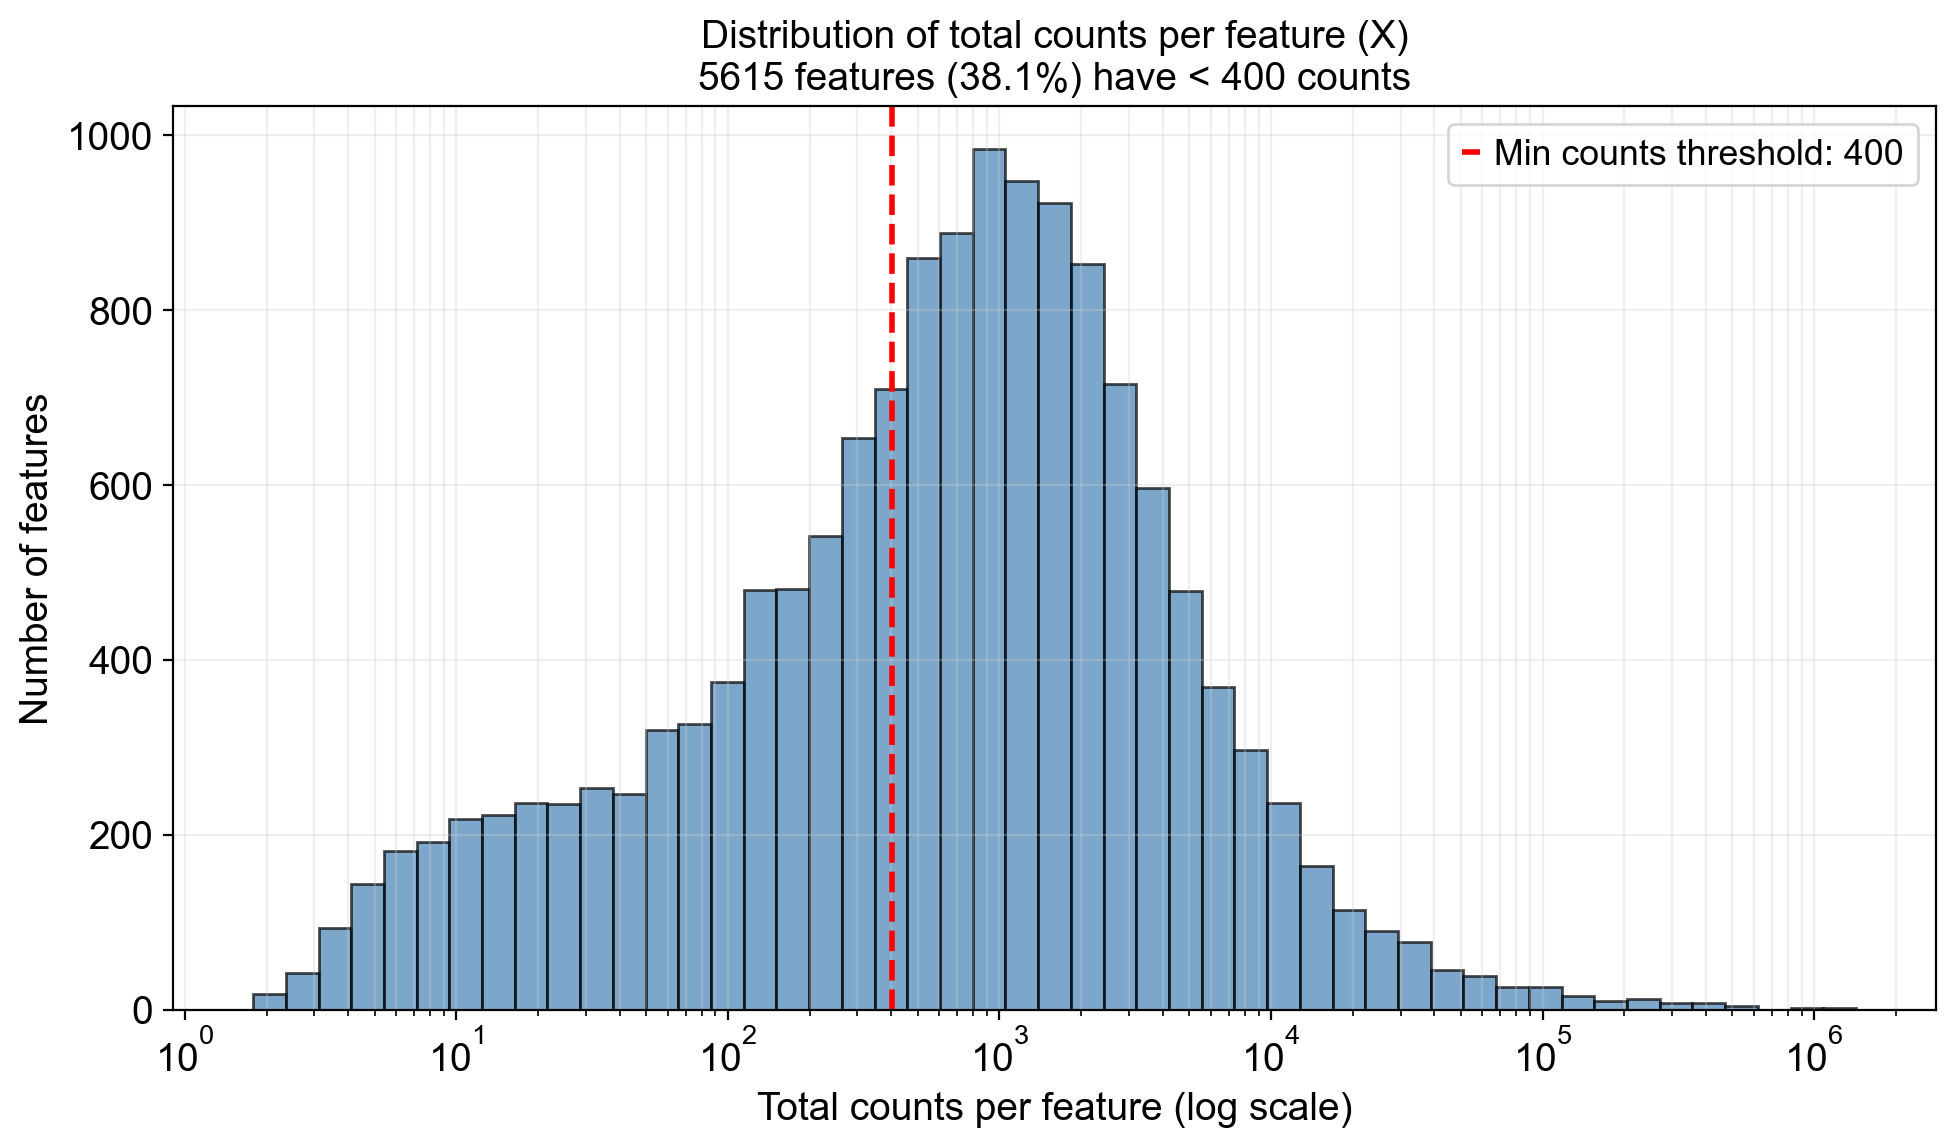

In [13]:
processing.plot_feature_counts_histogram(mdata["transcriptomics"], min_counts = READ_CUTOFF)
plt.show()

In [14]:
# filter to drop features with low counts
processing.filter_features_by_counts(mdata["transcriptomics"], min_counts = READ_CUTOFF)

## Log-transformation

Plot out some of the features they look pretty darn log-Normal and this generally a fair assumption for transcript- or protein-level data.

In [15]:
# add a pseudocount before logging
processing.log2_transform(mdata["transcriptomics"], pseudocount = 1)
# proteomics has a minimum value of 1 so no pseudocounts are needed before logging
processing.log2_transform(mdata["proteomics"], pseudocount = 0)

### Normalization

Apply iterative row and column centering as-per Forny et al., 2023.

In [16]:
processing.center_rows_and_columns_mudata(
    mdata,
    layer = "log2",
    new_layer_name = "log2_centered"
)

In [17]:
mdata

MuData object with n_obs × n_vars = 230 × 19537
  2 modalities
    transcriptomics:	221 x 9134
      obs:	'case', 'gender', 'n_passage', 'date_collection', 'date_freezing', 'consanguinity', 'onset_age', 'OHCblMinus', 'OHCblPlus', 'ratio', 'SimultOHCblMinus', 'SimultOHCblPlus', 'mut_category', 'AdoCblMinus', 'AdoCblPlus', 'SimultAdoCblMinus', 'SimultAdoCblPlus', 'wgs_zygosity', 'prot_mut_level', 'rnaseq_mut_level', 'acidosis', 'metabolic_acidosis', 'metabolic_ketoacidosis', 'ketosis', 'hyperammonemia', 'abnormal_muscle_tone', 'musc_hypotonia', 'musc_hypertonia', 'fct_respiratory_abnormality', 'dyspnea', 'tachypnea', 'reduced_consciousness', 'lethargy', 'coma', 'seizures', 'general_tonic_clonic_seizure', 'any_GI_problem', 'failure_to_thrive', 'any_delay', 'behavioral_abnormality', 'concurrent_infection', 'MMA_urine', 'MMA_plasma', 'ammonia_umolL', 'pH', 'base_excess', 'pCO2', 'glucose_mmolL', 'urine_ketones', 'dialysis', 'peritoneal_dialysis', 'insulin', 'diet', 'carnitine', 'cobalamin', 'bicarb', 'glucose_IV', 'cobalamin_responsive', 'MMA_urine_after_treat', 'cobalamin_dose_PO', 'cobalamin_dose_IM', 'carnitine_dose', 'antibiotic_treatment', 'protein_restriction', 'natural_protein_amount', 'synthetic_protein_amount', 'total_protein_amount', 'meals_per_day', 'calories_per_day', 'tube_feeding_day', 'tube_feeding_night', 'tube_feeding_overall', 'weight_centile_quant', 'length_centile_quant', 'head_circumfernce_quant', 'language_delay', 'IQ', 'any_neurological_abnormalities_chronic', 'impaired_kidney_fct', 'uric_acid', 'creatinine', 'urea', 'hemat_abnormality', 'anemia', 'neutropenia', 'skin_abnormalities', 'hearing_impairment', 'osteoporosis', 'failure_to_thrive_chronic', 'cCSS', 'global_dev_delay_chr', 'hypotonia_chr', 'basal_ganglia_abnormality_chr', 'nCSSonlyNeuro', 'failure_to_thrive_or_tube_feeding', 'cssModif', 'irritability', 'hyperventilation', 'hypothermia', 'somnolence', 'vomiting', 'dehydration', 'feeding_problem', 'GFR', 'responsive_to_acute_treatment'
      uns:	'feature_filtering', 'log2_transform'
      layers:	'log2', 'log2_centered'
    proteomics:	230 x 4788
      obs:	'case', 'gender', 'n_passage', 'date_collection', 'date_freezing', 'consanguinity', 'onset_age', 'OHCblMinus', 'OHCblPlus', 'ratio', 'SimultOHCblMinus', 'SimultOHCblPlus', 'mut_category', 'AdoCblMinus', 'AdoCblPlus', 'SimultAdoCblMinus', 'SimultAdoCblPlus', 'wgs_zygosity', 'prot_mut_level', 'rnaseq_mut_level', 'acidosis', 'metabolic_acidosis', 'metabolic_ketoacidosis', 'ketosis', 'hyperammonemia', 'abnormal_muscle_tone', 'musc_hypotonia', 'musc_hypertonia', 'fct_respiratory_abnormality', 'dyspnea', 'tachypnea', 'reduced_consciousness', 'lethargy', 'coma', 'seizures', 'general_tonic_clonic_seizure', 'any_GI_problem', 'failure_to_thrive', 'any_delay', 'behavioral_abnormality', 'concurrent_infection', 'MMA_urine', 'MMA_plasma', 'ammonia_umolL', 'pH', 'base_excess', 'pCO2', 'glucose_mmolL', 'urine_ketones', 'dialysis', 'peritoneal_dialysis', 'insulin', 'diet', 'carnitine', 'cobalamin', 'bicarb', 'glucose_IV', 'cobalamin_responsive', 'MMA_urine_after_treat', 'cobalamin_dose_PO', 'cobalamin_dose_IM', 'carnitine_dose', 'antibiotic_treatment', 'protein_restriction', 'natural_protein_amount', 'synthetic_protein_amount', 'total_protein_amount', 'meals_per_day', 'calories_per_day', 'tube_feeding_day', 'tube_feeding_night', 'tube_feeding_overall', 'weight_centile_quant', 'length_centile_quant', 'head_circumfernce_quant', 'language_delay', 'IQ', 'any_neurological_abnormalities_chronic', 'impaired_kidney_fct', 'uric_acid', 'creatinine', 'urea', 'hemat_abnormality', 'anemia', 'neutropenia', 'skin_abnormalities', 'hearing_impairment', 'osteoporosis', 'failure_to_thrive_chronic', 'cCSS', 'global_dev_delay_chr', 'hypotonia_chr', 'basal_ganglia_abnormality_chr', 'nCSSonlyNeuro', 'failure_to_thrive_or_tube_feeding', 'cssModif', 'irritability', 'hyperventilation', 'hypothermia', 'somnolence', 'vomiting', 'dehydration', 'feeding_problem', 'GFR', 'responsive_to_acute_trea

## Exploratory Data Analysis

Before digging into the results of the study its a good idea to understand the major factors driving the studies variation. Ideally, these are the variables of interest (i.e, case) but to the extent this is not true then we may have to add additional covariates or hunt for batch effects. Its also a good idea to generate a scree plot to see whether the variation is driven by a few known or unknown variables or if there are many sources of variation. Since this study has a large number of patient-derived samples I'm guessing we're in the latter scenario.

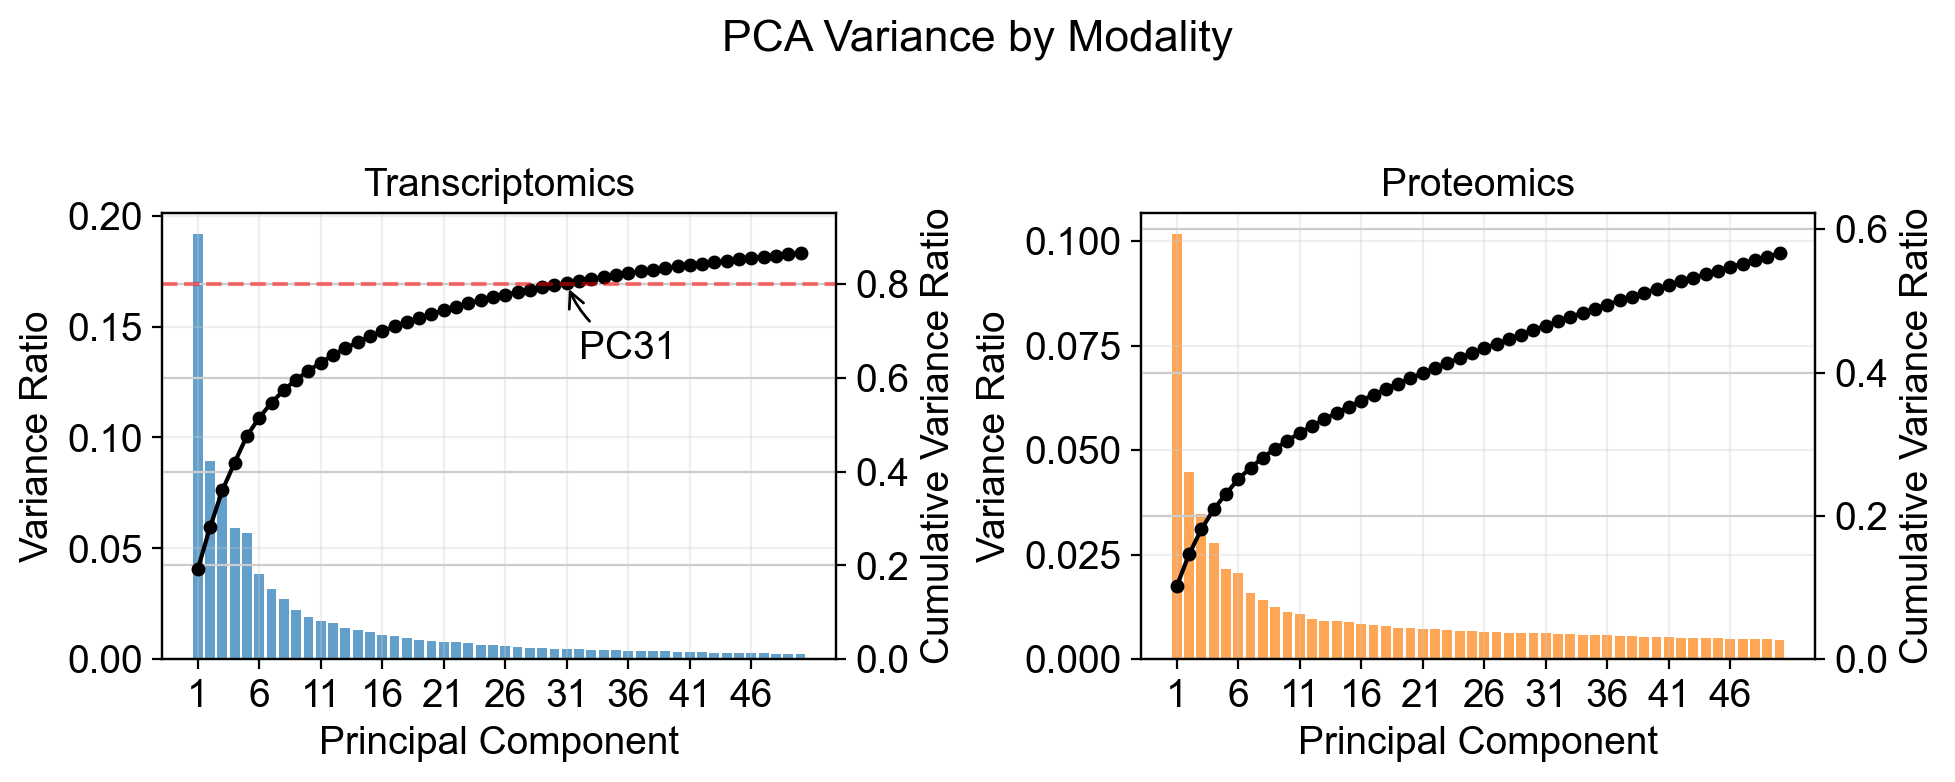

In [18]:
import scanpy as sc

# Process each modality
for modality in ['transcriptomics', 'proteomics']:
    # add PCs
    sc.pp.pca(mdata[modality], layer = ANALYSIS_LAYER)
    
eda.plot_mudata_pca_variance(mdata, n_pcs = int(50))
plt.show()

Filtering out 'MMA_plasma': only 4.5% non-missing values (threshold: 50%)
Filtering out 'cobalamin_dose_PO': only 10.9% non-missing values (threshold: 50%)
Filtering out 'cobalamin_dose_IM': only 10.9% non-missing values (threshold: 50%)
Filtering out 'carnitine_dose': only 29.0% non-missing values (threshold: 50%)
Filtering out 'synthetic_protein_amount': only 17.2% non-missing values (threshold: 50%)
Filtering out 'meals_per_day': only 17.6% non-missing values (threshold: 50%)
Filtering out 'IQ': only 2.3% non-missing values (threshold: 50%)
Filtering out 'urea': only 2.7% non-missing values (threshold: 50%)
Filtering out 'GFR': only 2.7% non-missing values (threshold: 50%)
Filtering out 'MMA_plasma': only 4.3% non-missing values (threshold: 50%)
Filtering out 'cobalamin_dose_PO': only 11.7% non-missing values (threshold: 50%)
Filtering out 'cobalamin_dose_IM': only 10.9% non-missing values (threshold: 50%)
Filtering out 'carnitine_dose': only 29.6% non-missing values (threshold: 50%

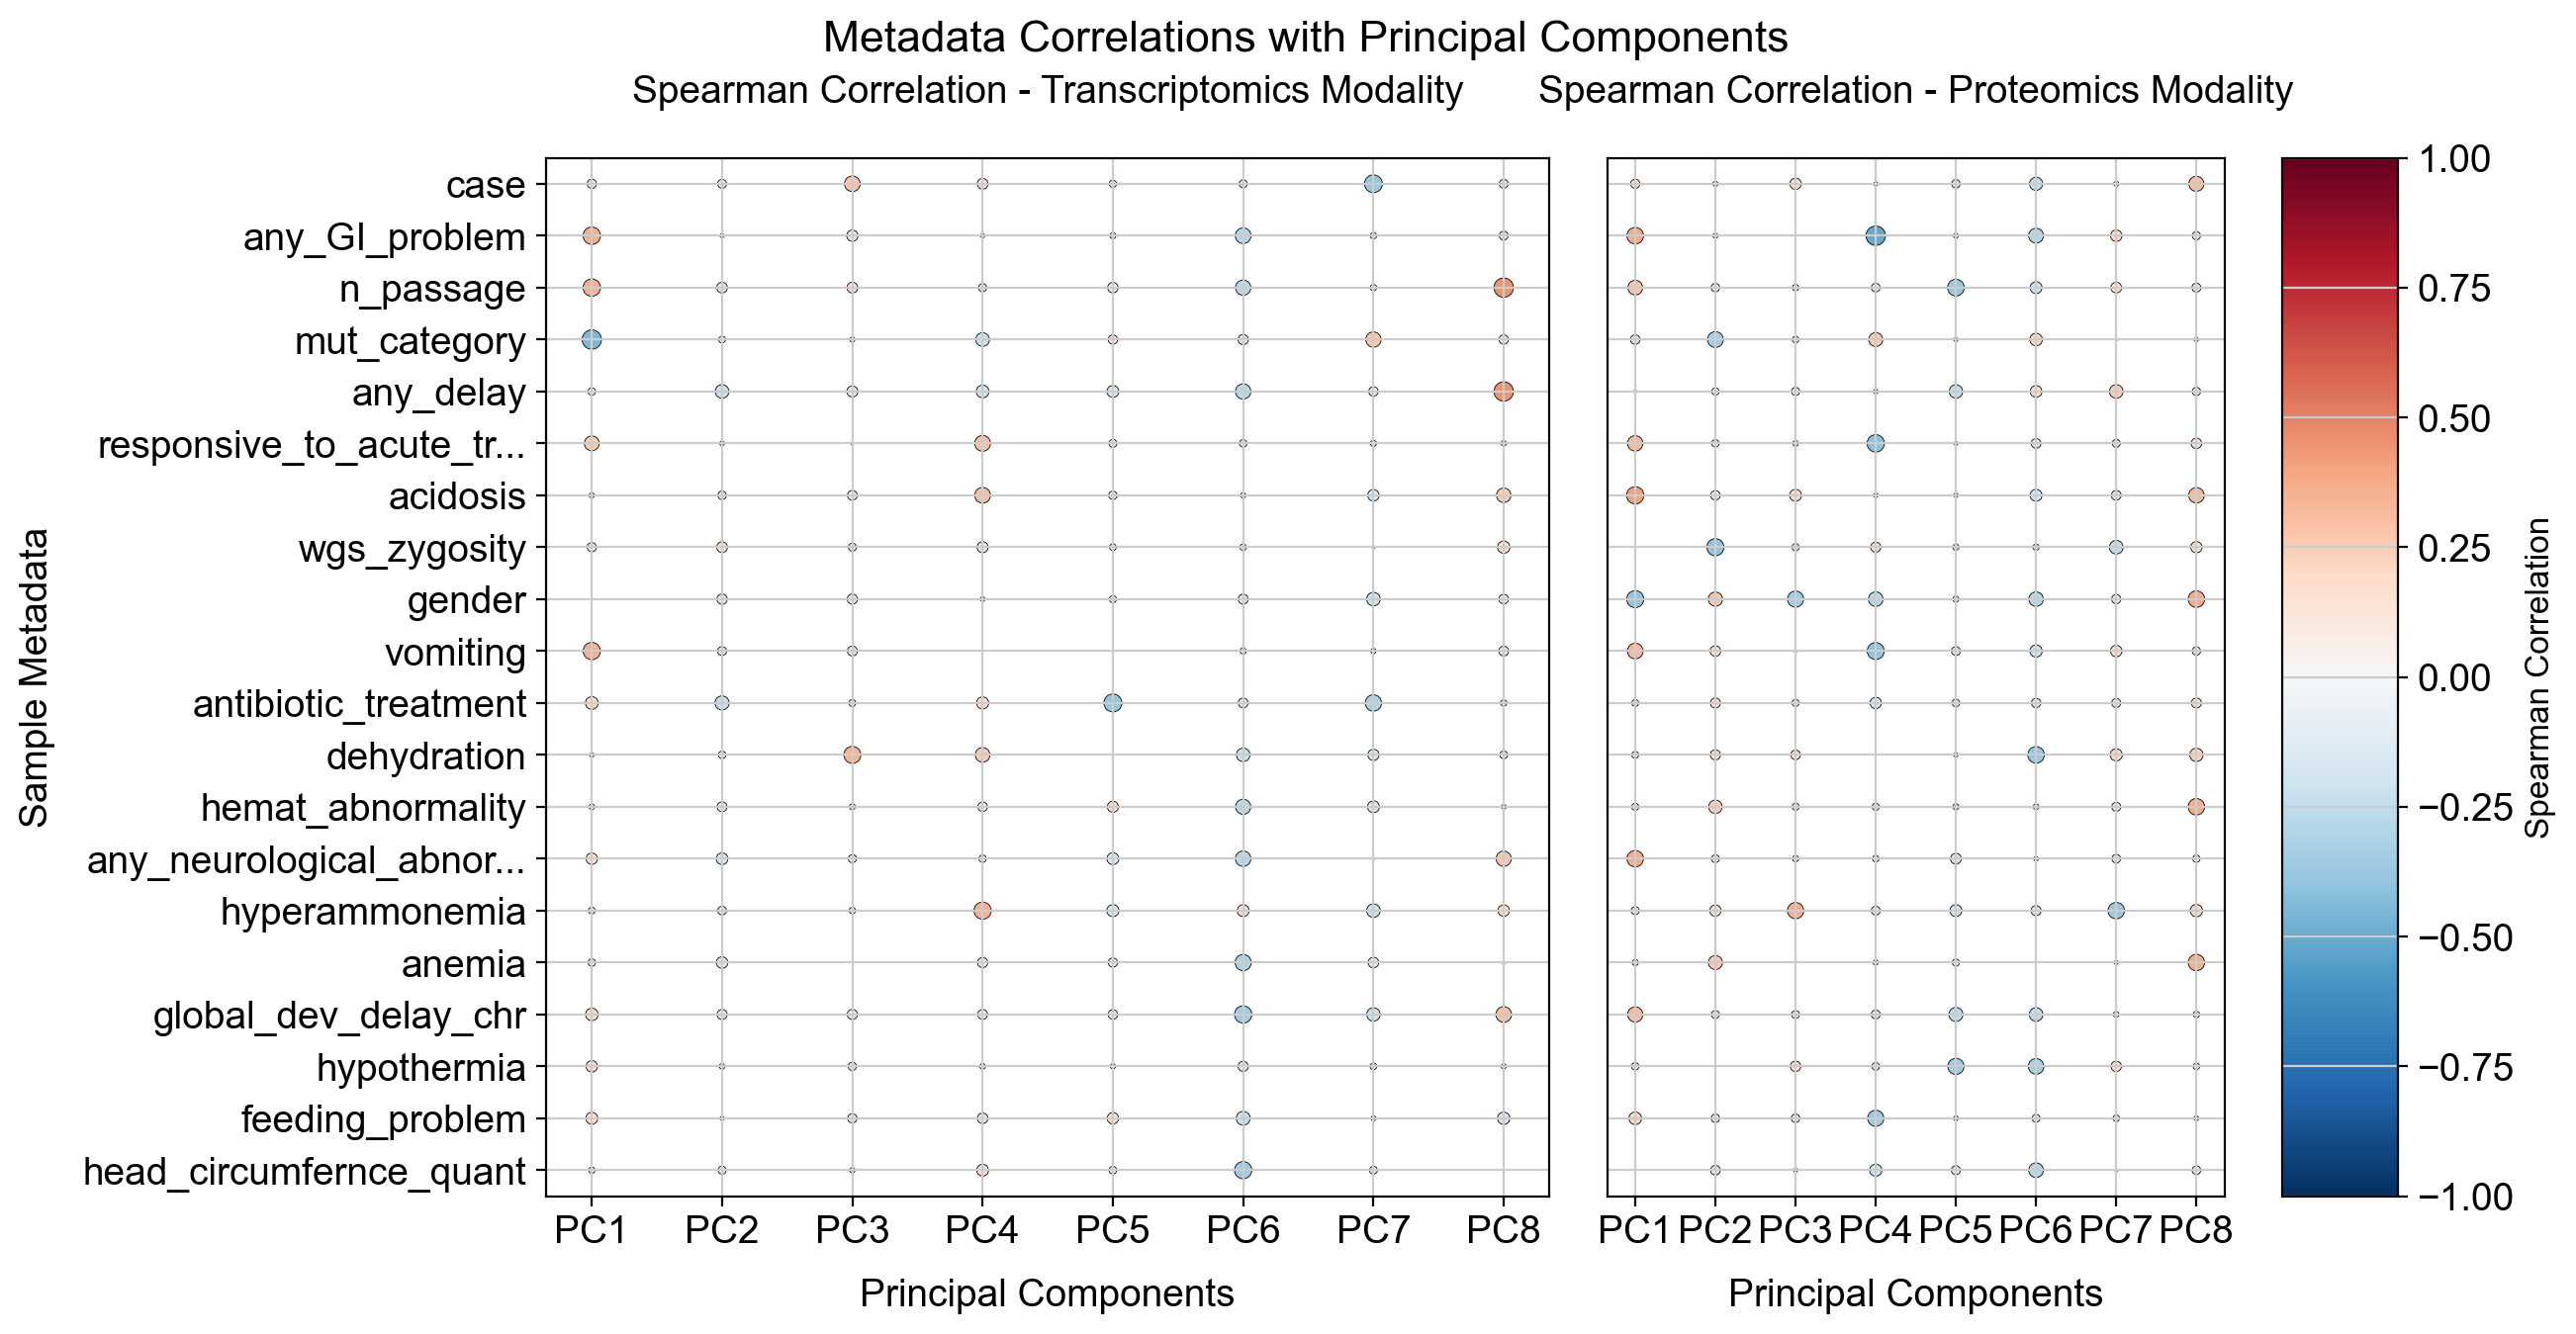

In [19]:

results = eda.analyze_pc_metadata_correlation_mudata(
    mdata,
    n_pcs=8,
    prioritized_vars=['case'],  # This will always show 'case' variable at the top
    pca_kwargs={'svd_solver': 'arpack'},
    
    figsize = (12, 7)
)

plt.show()

Processing transcriptomics modality...
Processing proteomics modality...


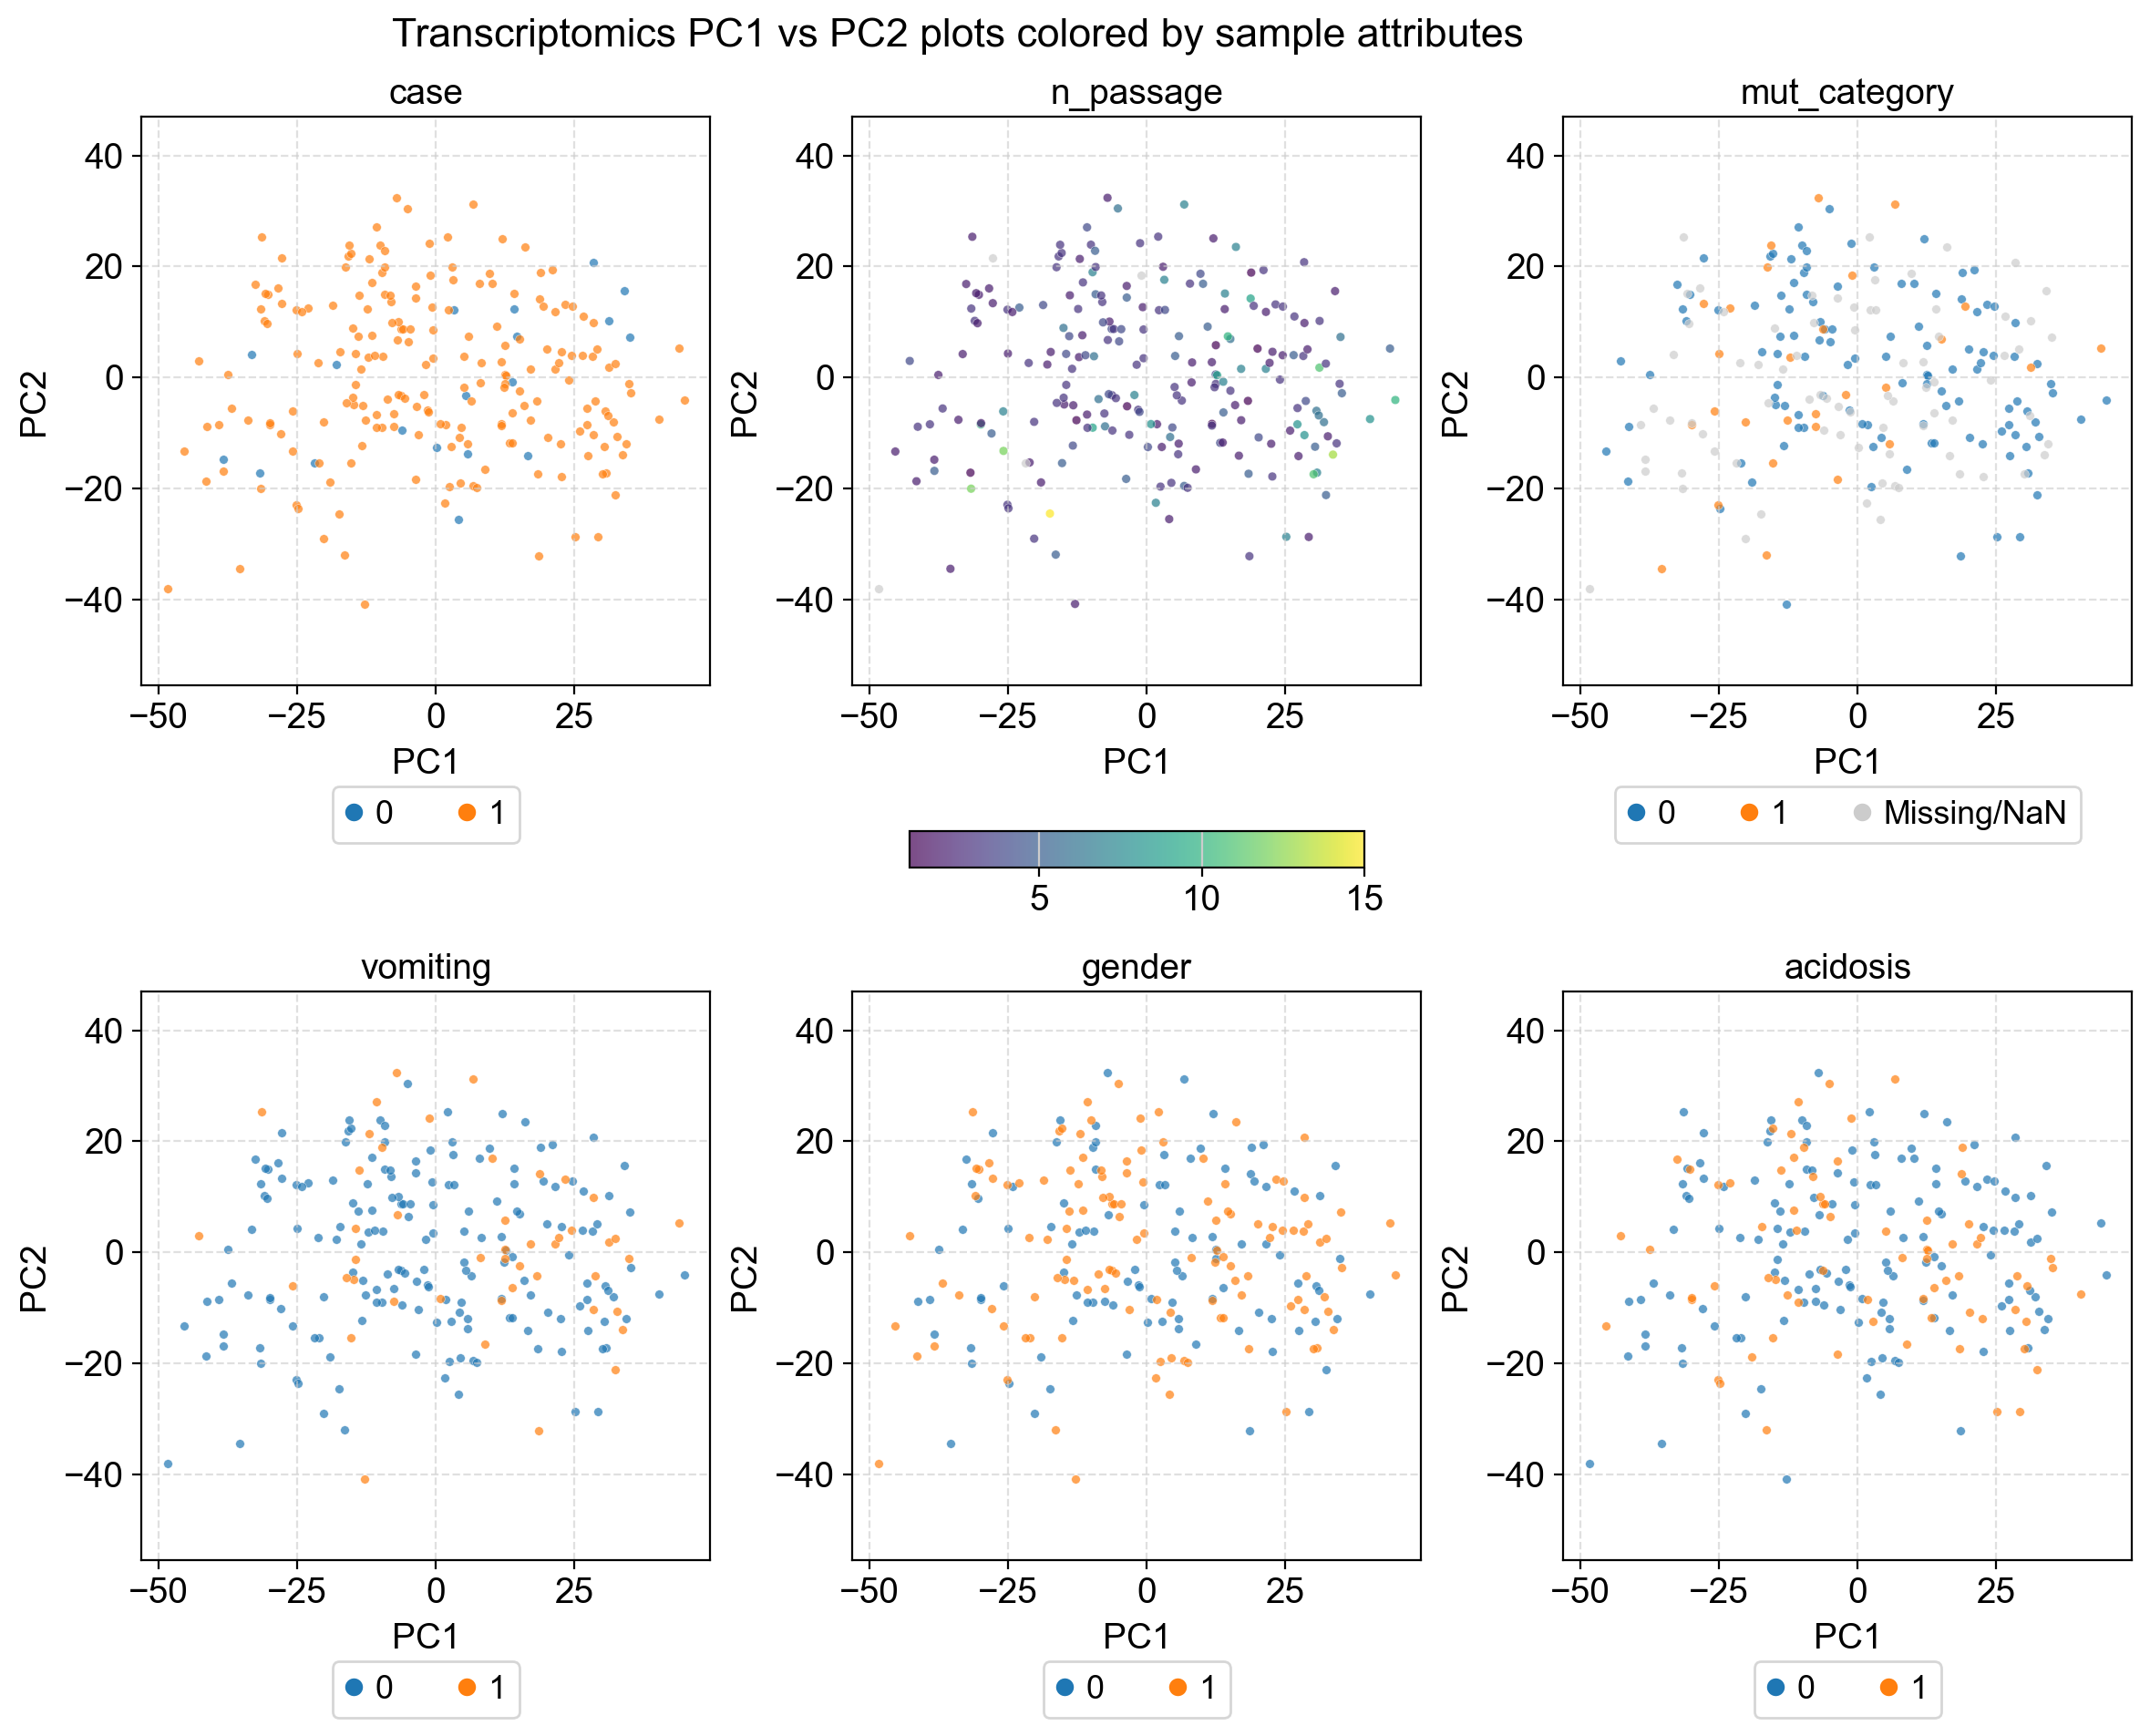

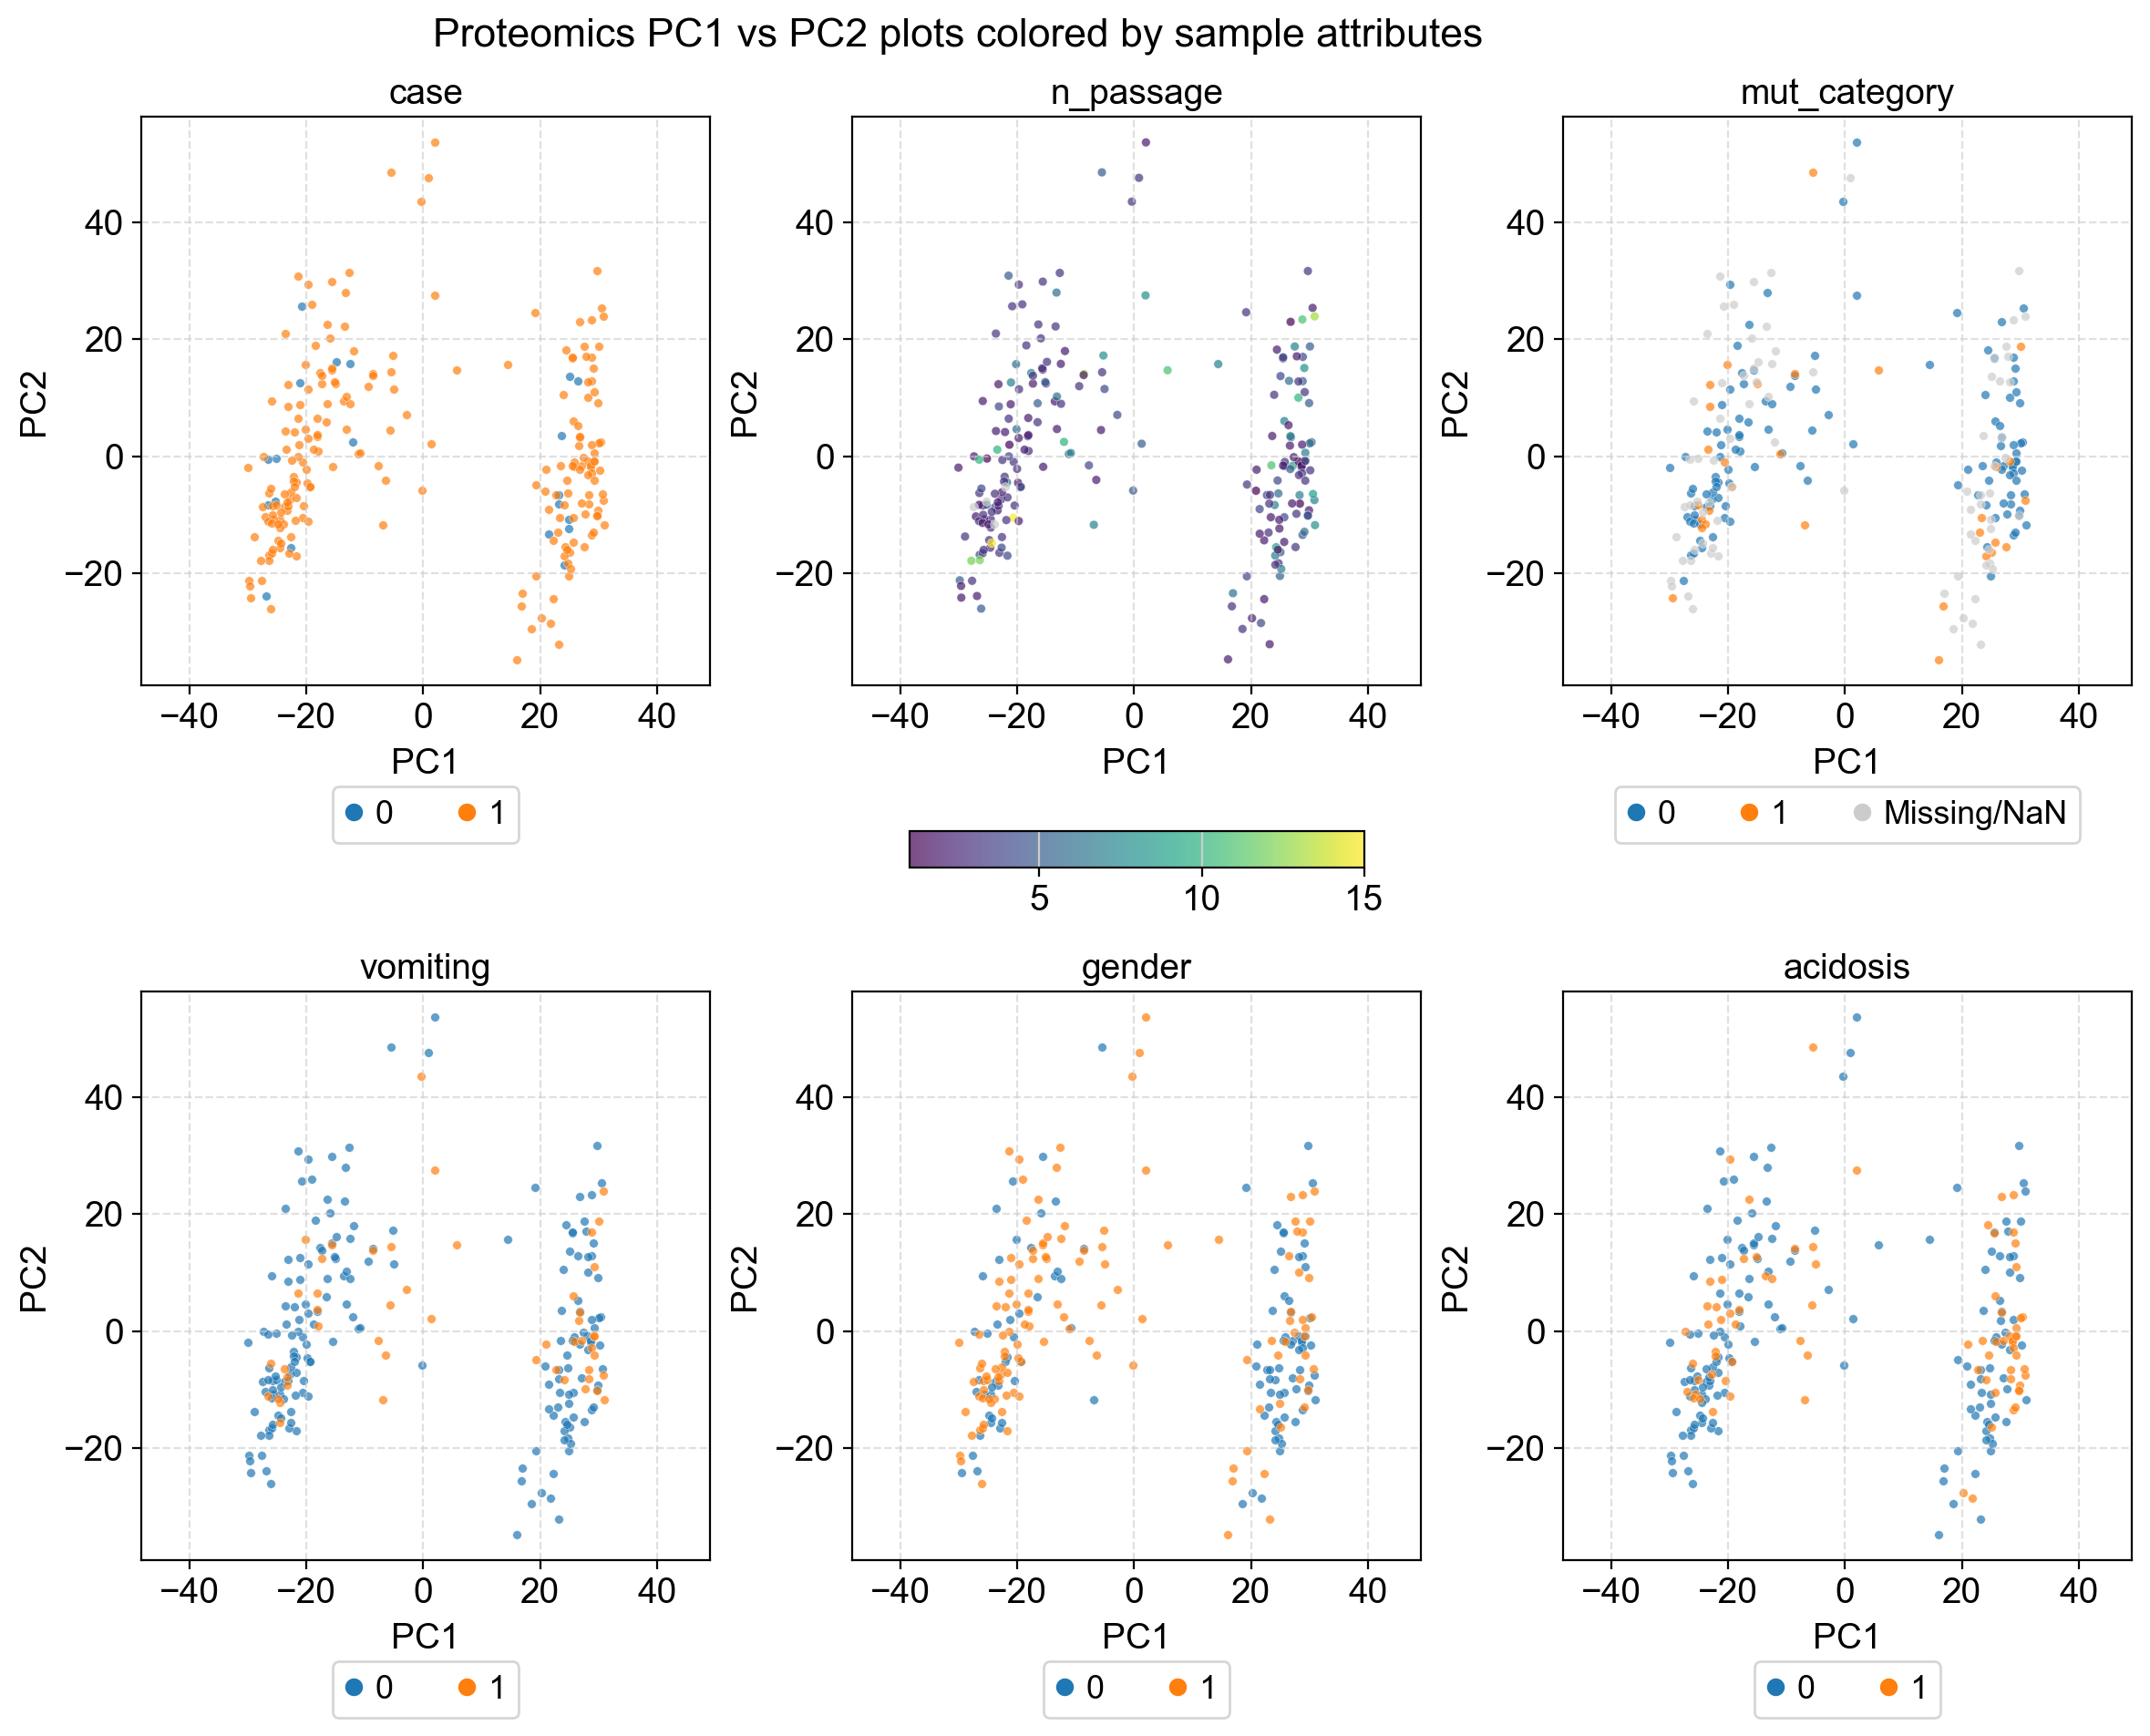

In [20]:
SAMPLE_ATTRIBUTES = ["case", "n_passage", "mut_category","vomiting", "gender", "acidosis"]

eda.plot_mudata_pcs(
    mdata, 
    metadata_attrs=SAMPLE_ATTRIBUTES,
    figsize = (14, 10),
    point_size = 12,
    legend = True
)
plt.show()

Processing transcriptomics modality...
Processing proteomics modality...


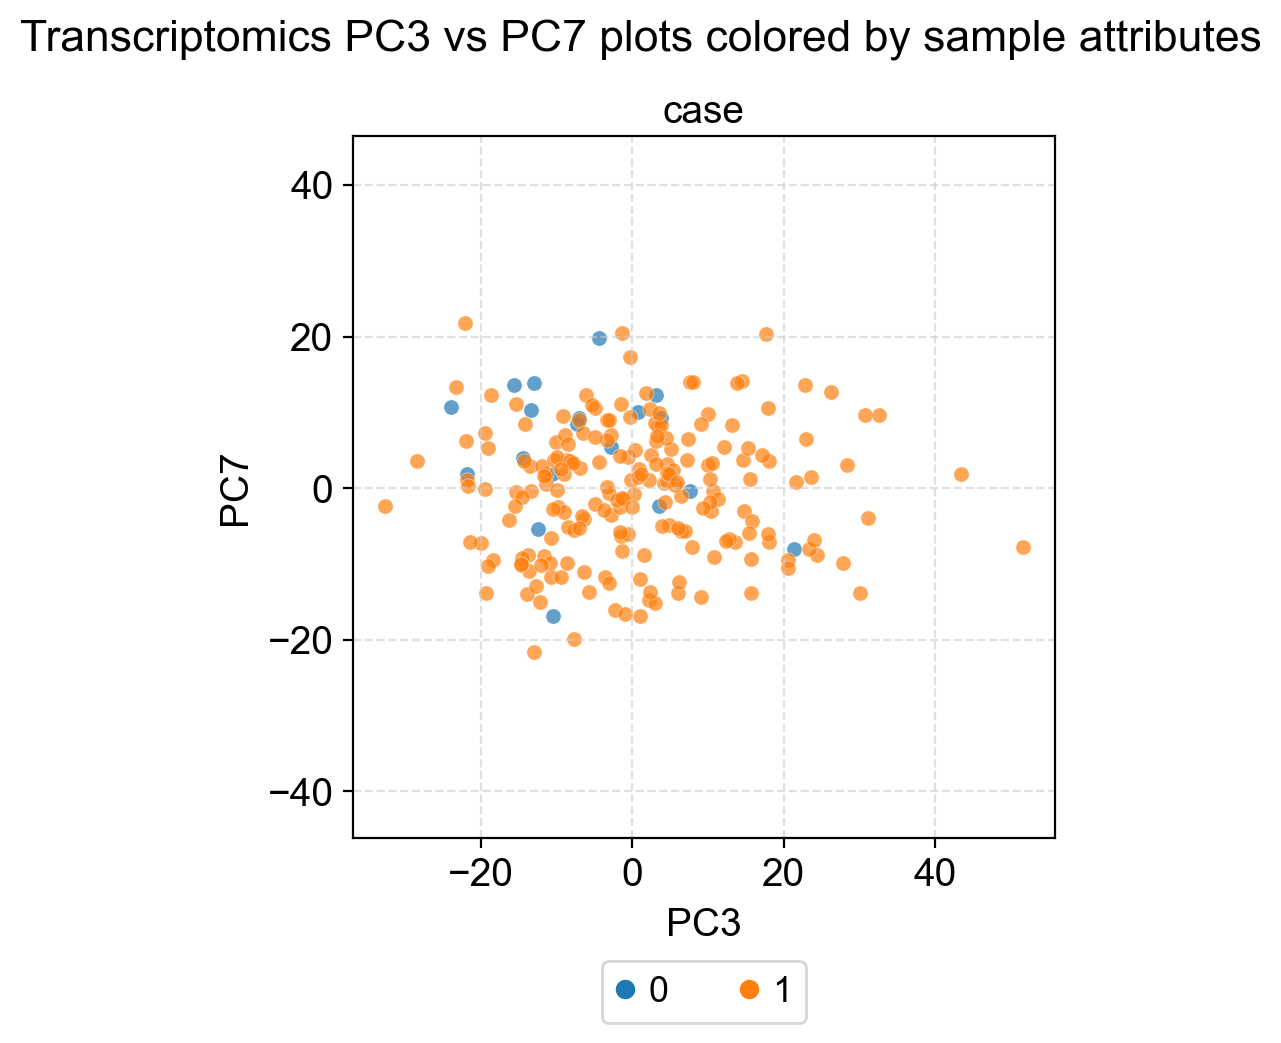

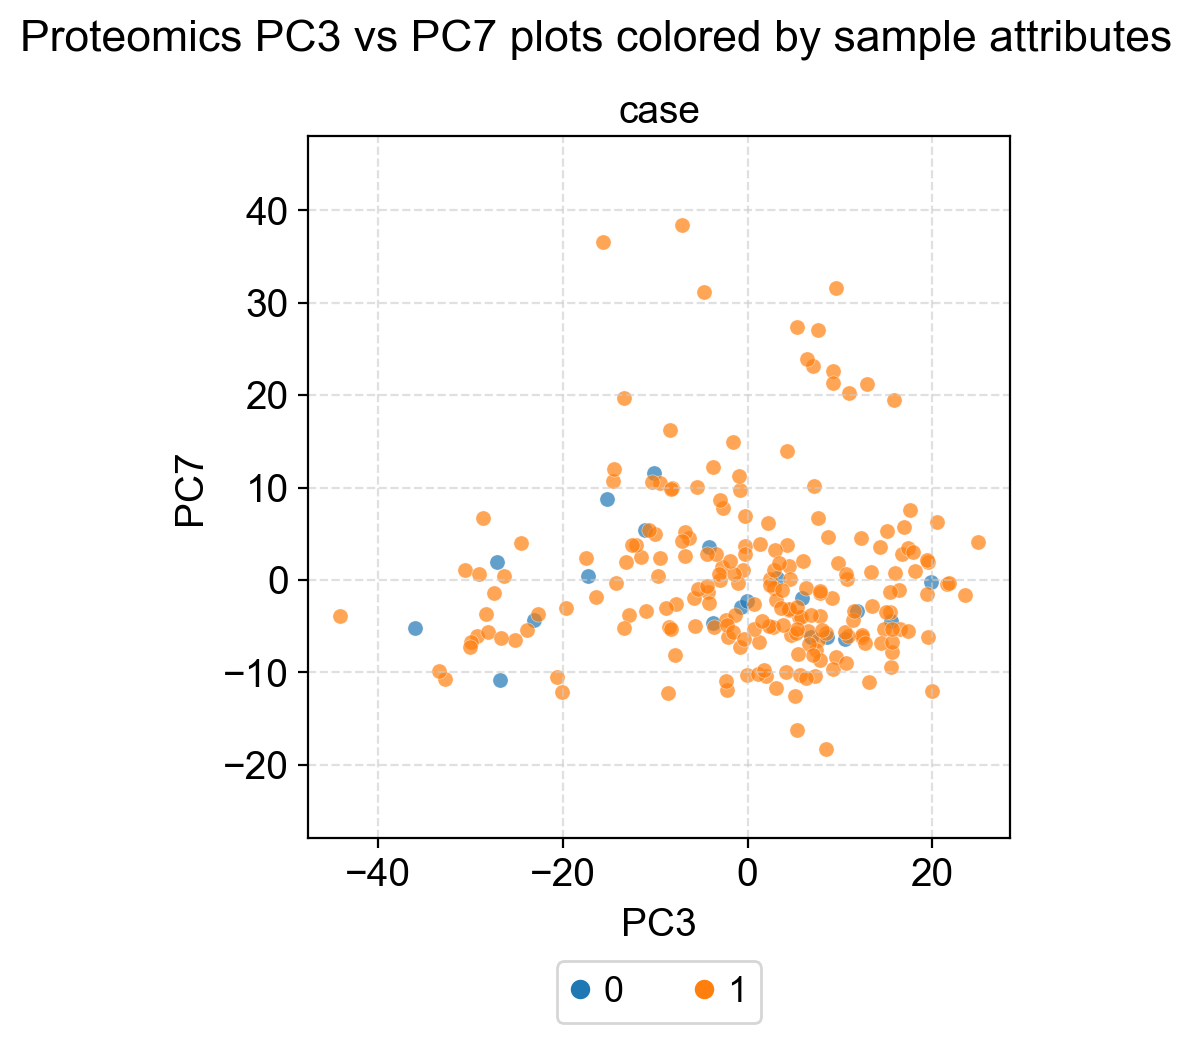

In [21]:
eda.plot_mudata_pcs(mdata, metadata_attrs = "case", pc_x = 3, pc_y = 7)
plt.show()

From the exploratory data analysis we can make a few observations about the dataset(s):

1. From the Screeplot it is clear that there are complex sources of variation in these datasets - from the elbow of the plot, there are likely 8-10 major principal components but even this number only captures 50-60% of the variation in the datasets.
2. The lower fraction of total variation explained in the proteomics than the transcriptomics datasets likely reflect higher technical variation in this dataset.
3. The PC corrplot, and followups plotting pairs of princial components highlight that the the primary attribute of interest, case (i.e, affecteds vs. unaffecteds), is a relatively minor driver of variation in the dataset. It shows up weakly correlated with PC3 in both the transcriptomics' and proteomics' datasets (note that the analysis of each modality is totally separate).
4. PC1 in the proteomics data is bimodal but the two categories do not map onto any of the provided covariates (e.g., gender). Ideally, we'd want to find or define a variable which nicely captures these two groups but I'm not familiar enough with this dataset to do so (I'm guessing its a modest technical batch effect). Unexplained variation of this magnitude is problematic but not a dealbreaker for downstream analyses like regression as it will decrease power and may increase bias depending on the correlation of case or other variables of interest to the latent variable.
5. PC1 in the transcriptomics data is also tricky to understand, there is a rough correlation with the # of passages a cell line has gone through and its mutational status. This may reflect biases in how cell lines are used (preserving those that are particularly precious by putting them through fewer passages) or shifts in the biology of the cell lines as they acclimate to laboratory conditions.

## Generating multi-omic profiles

To map our results onto Napistu network representations we need to generate a set of feature-level summaries. This can be done in multiple ways but for this analysis we'll use a supervised method, differential expression analysis, and an unsupervised one, factor analysis.

### Differential Expression Analysis

I've always done diffex in R, using data modality agnostic methods like regression, and modality-specific methods like DESeq2. It looks like there is a Python implementation of DESeq2 `pydeseq2.dds.DeseqDataSet` but since the transcript counts are not integers this framework is not appropriate. As a result we can just treat the transcripts and proteins equivalently and perform feature-wise regressions to estimate the effect of `case`.

In [22]:
# List of modalities to process
modalities = ["transcriptomics", "proteomics"]  # Add other modalities as needed

# Process each modality
for modality in modalities:
    print(f"Processing {modality}...")
    
    # Skip if modality doesn't exist in the mdata object
    if modality not in mdata.mod:
        print(f"Modality {modality} not found in MuData object. Skipping.")
        continue
    
    # Apply regression per feature
    summaries = profiles.apply_regression_per_feature(
        mdata[modality],
        REGRESSION_FORMULA,
        n_jobs=4,
        layer = ANALYSIS_LAYER,
        progress_bar = False
    )
    
    # Add results to the AnnData object
    # TO DO - the unstructured results here prevent serialization to a .h5mu
    profiles.add_regression_results_to_anndata(
        mdata[modality],
        summaries,
        fdr_cutoff=FDR_CUTOFF
    )

Processing transcriptomics...
Starting regression analysis with 4 cores...
Completed regression analysis for 18268 feature-coefficient pairs.
Processing proteomics...
Starting regression analysis with 4 cores...
Completed regression analysis for 9576 feature-coefficient pairs.


Processing transcriptomics...
Processing proteomics...


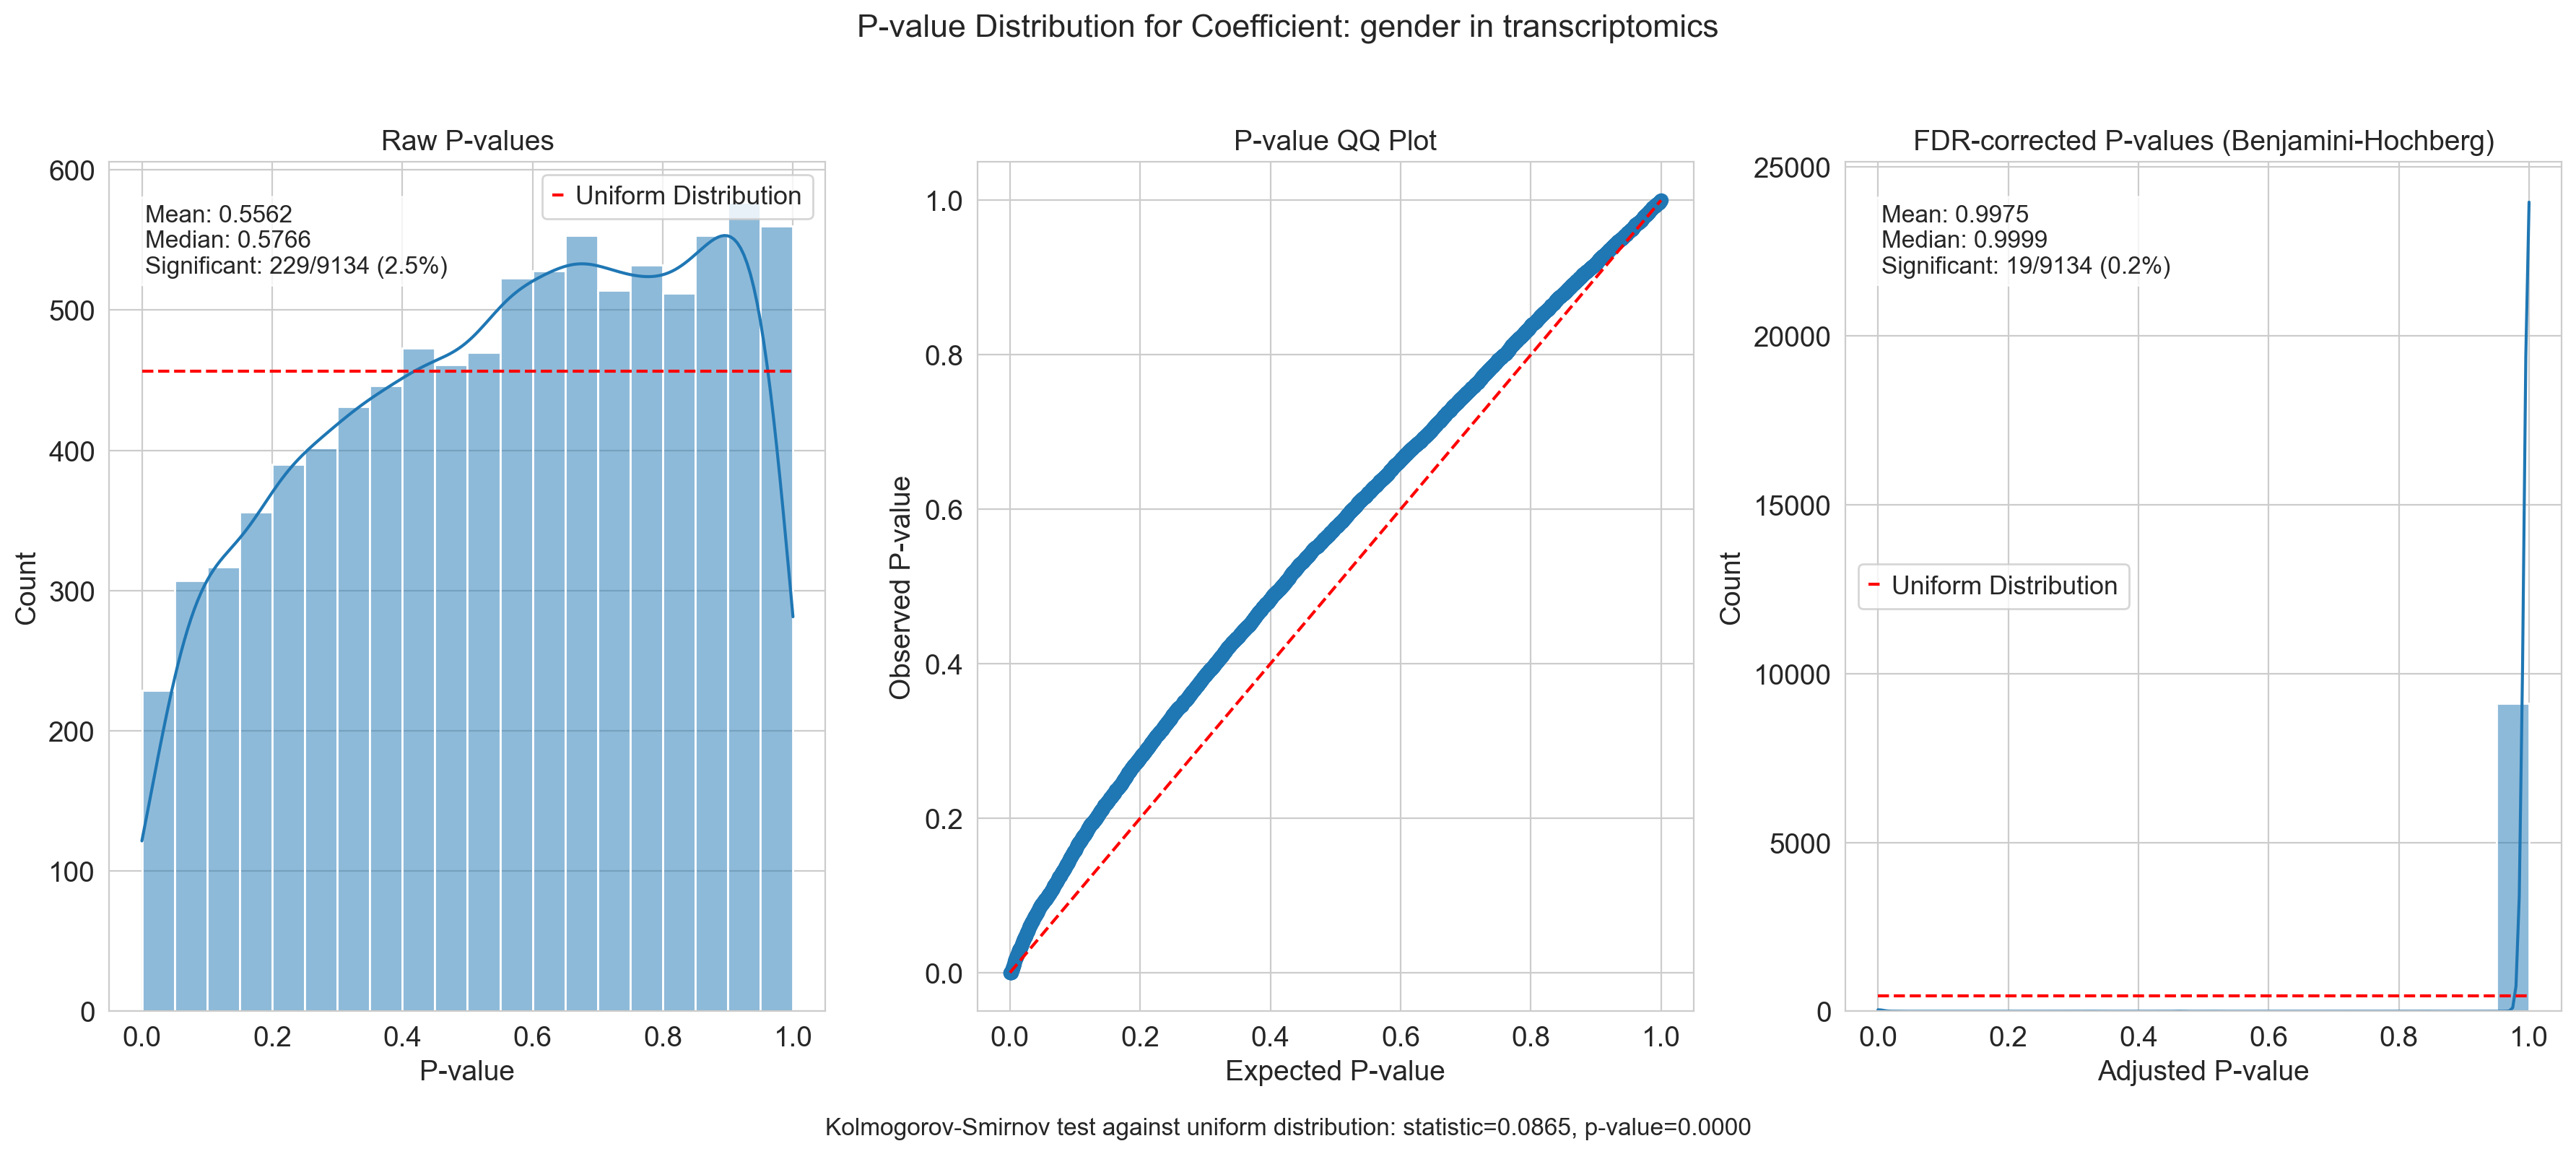

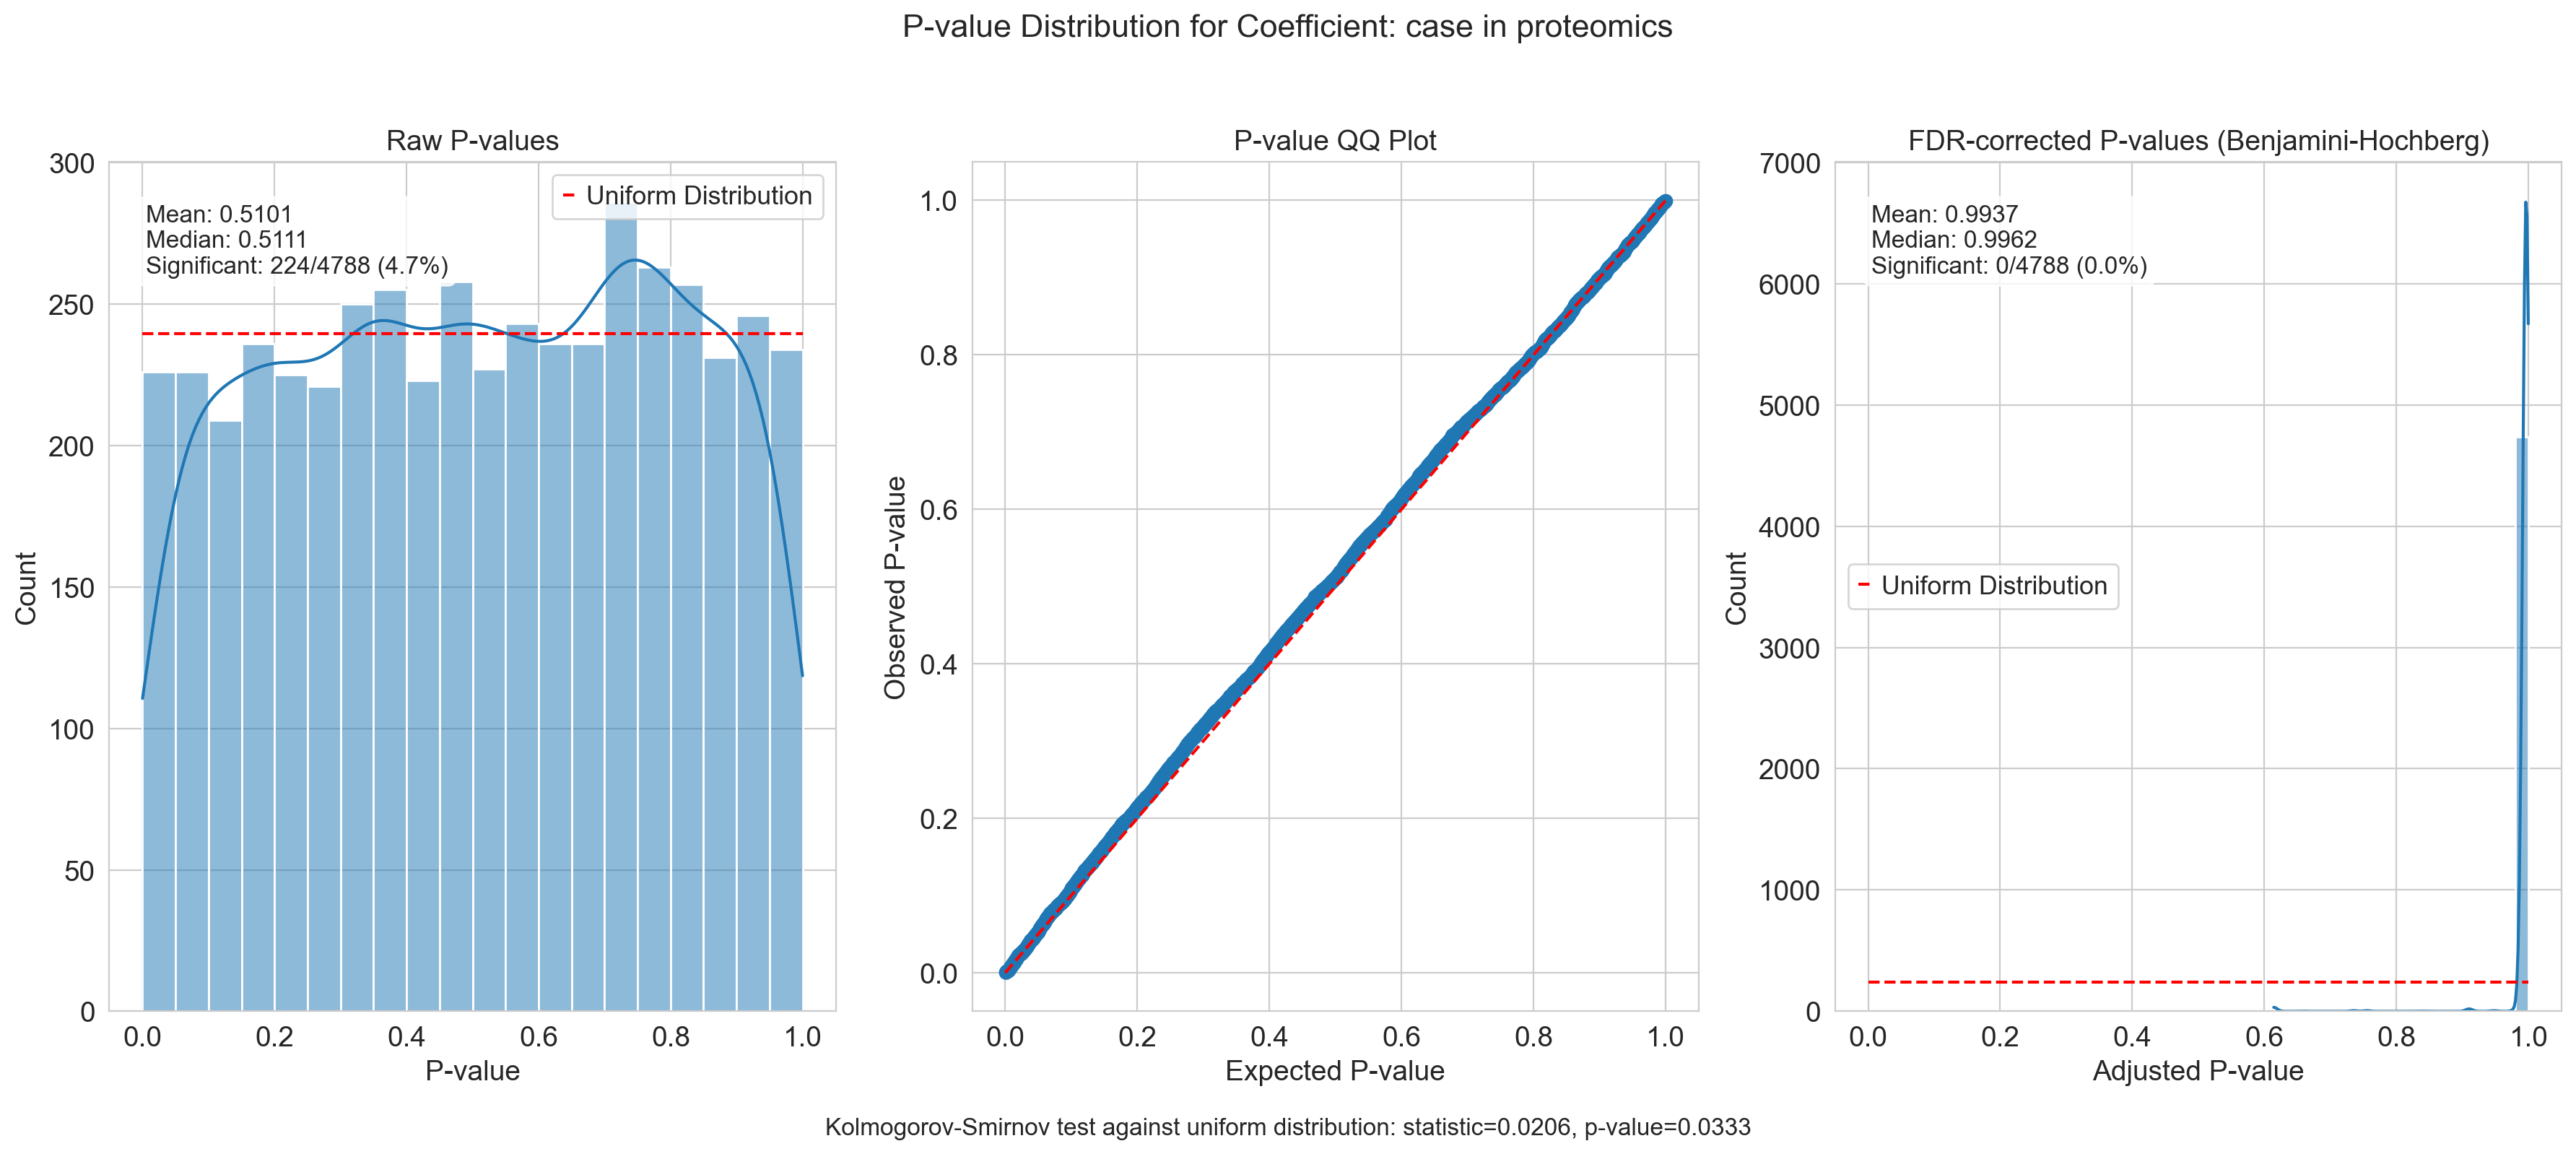

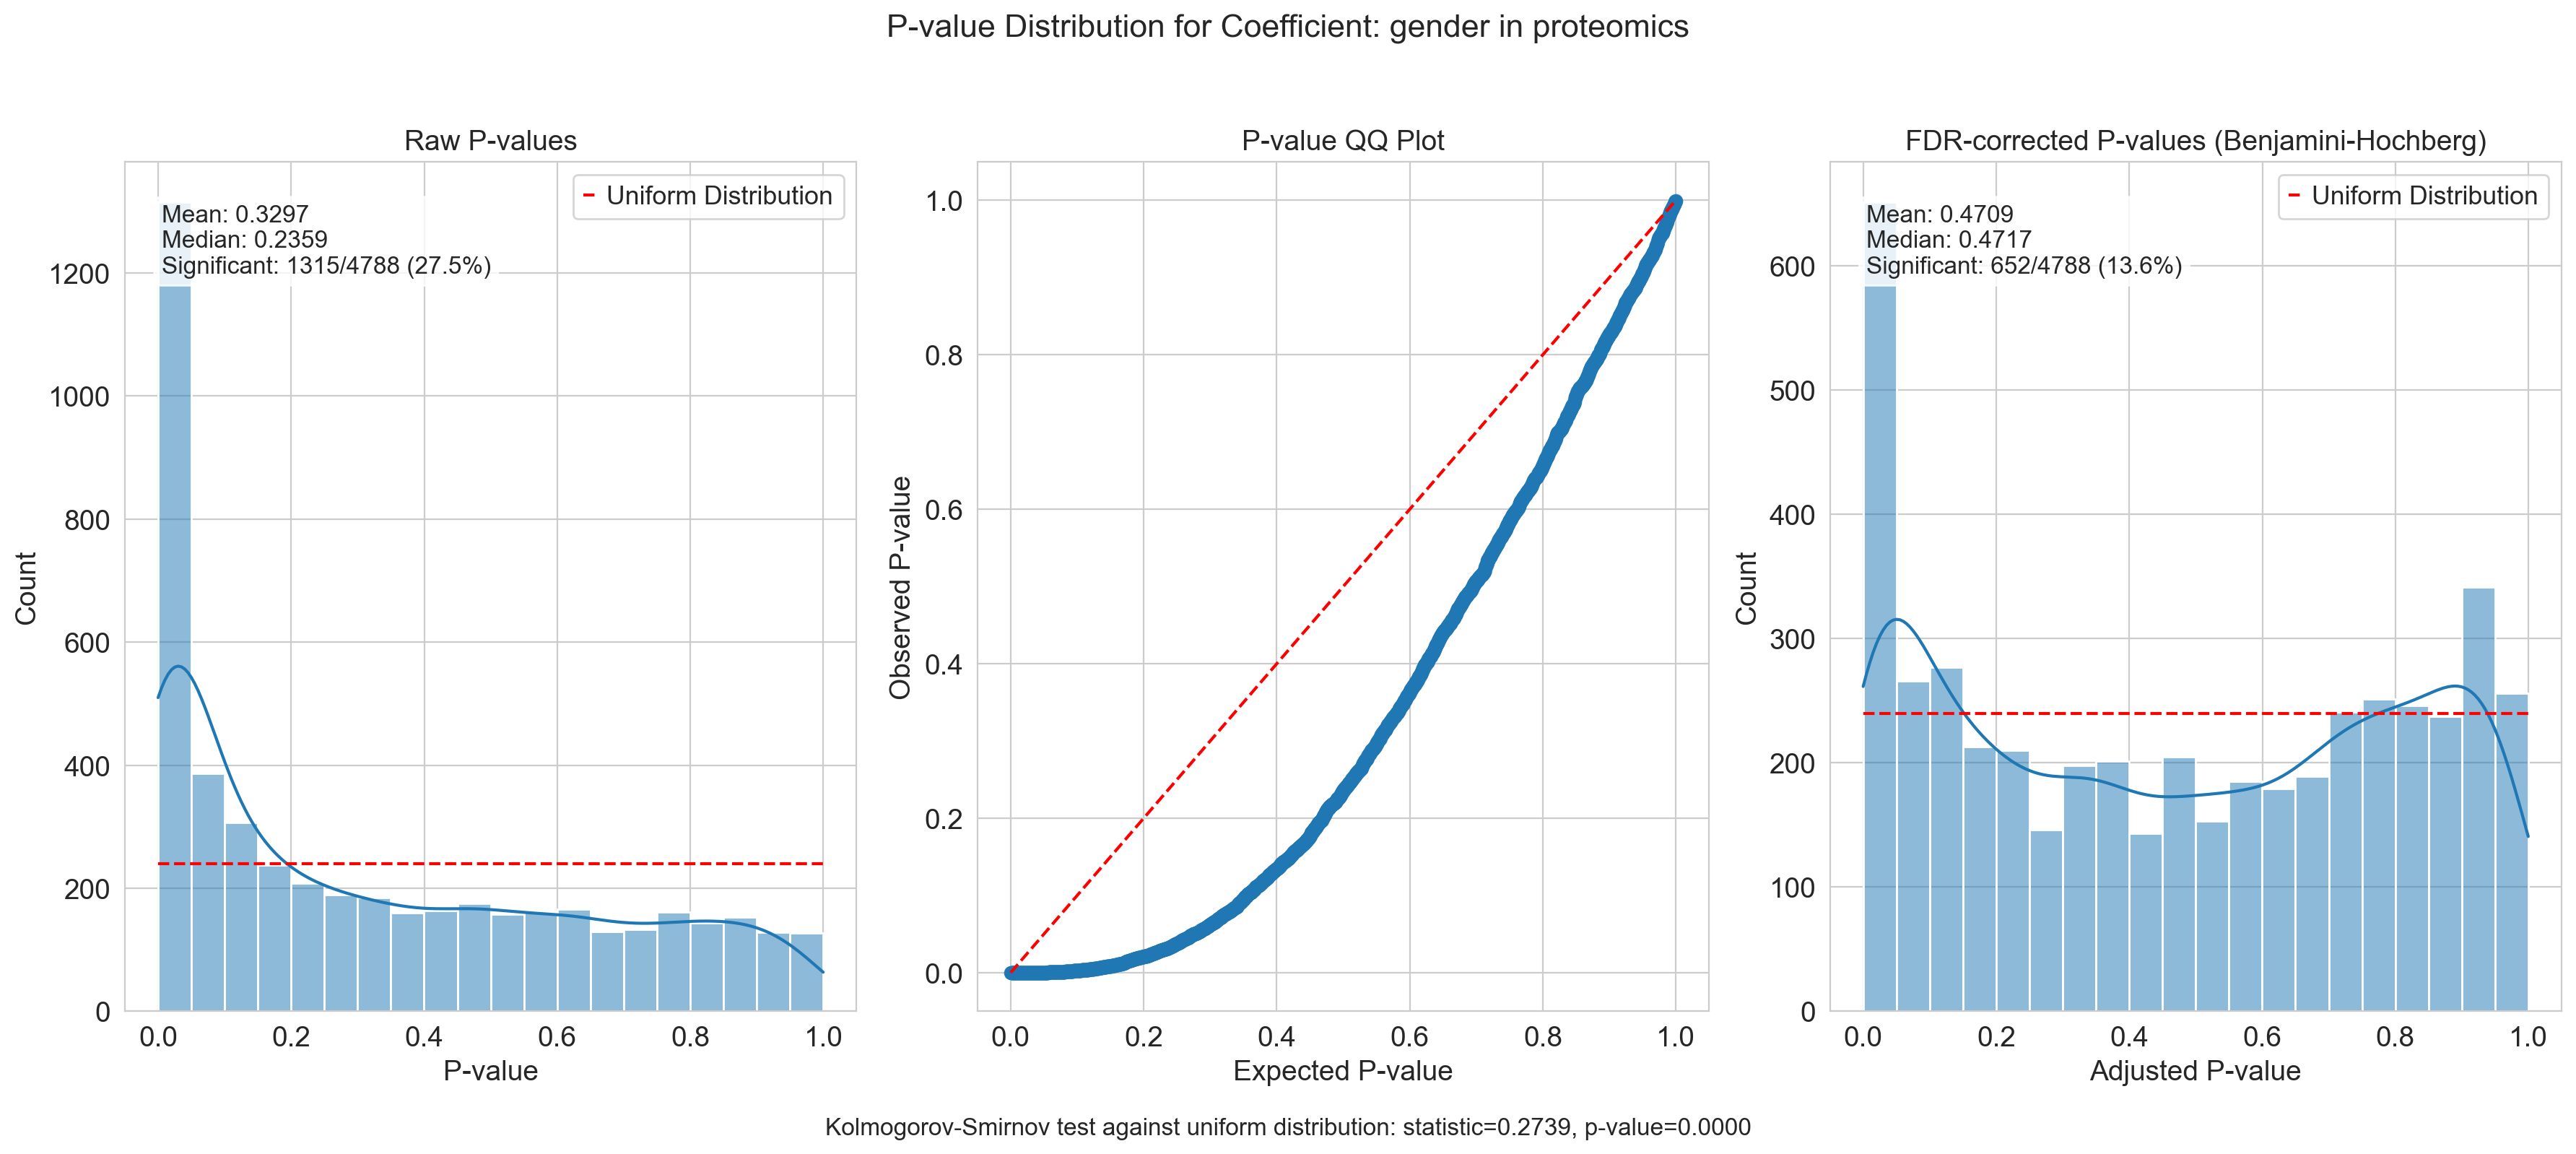

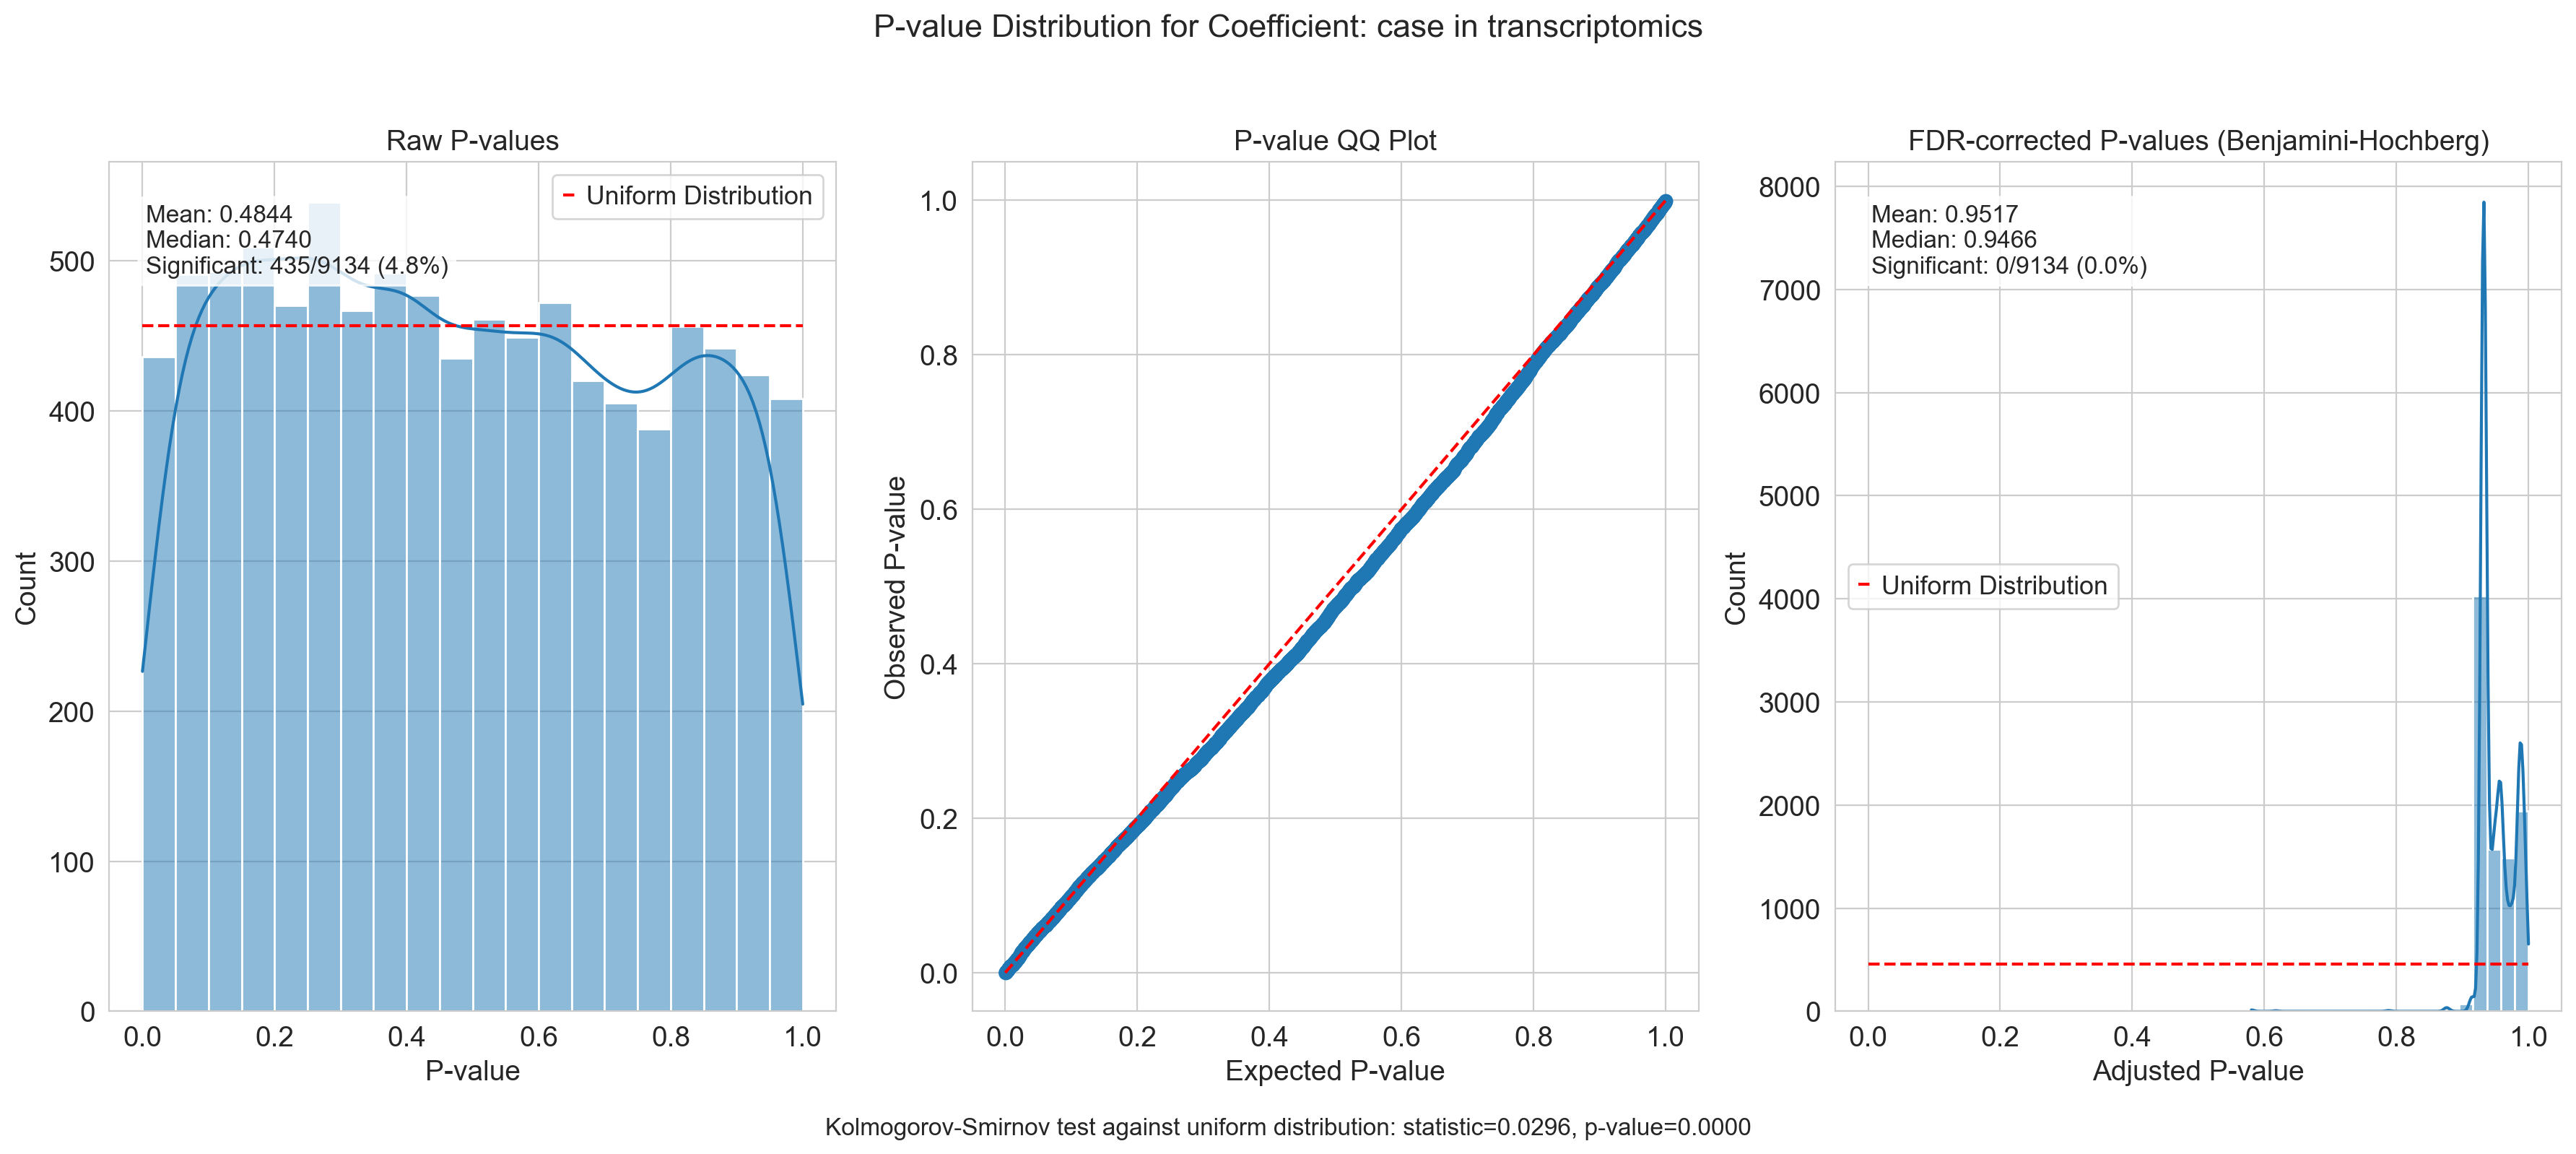

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

Histogram generation complete.


In [23]:
profiles.plot_pvalue_histograms(mdata)
plt.show()

We knew before applying regression analysis that cases were only loosly correlated with the leading PCs and there is also a large case imbalance with only ~12 unaffecteds.

It seems like the signal for `case` is really weak in general so it may not be the right measure for assessing disease biology, relative to a marker of disease severity like `onset_age` or `responsive_to_acute_treatment`.

The p-value histograms for gender show statistical significance in proteomics, and less-significance than expected by chance in the transcriptomics. This is pathological and suggests confounding (resulting in biased p-values) and/or unaccounted for covariates (as was already expected from EDA).


### Factor Analysis

Since we have two data modalities and we'd like to find patterns of covaration which span both data modalities we can 

In [24]:
import muon

# update the MuData object so `nvars and `nobs` are appropriate`
intersected_mdata = MuData({k: v for k, v in mdata.mod.items()})

muon.pp.intersect_obs(intersected_mdata)  # This modifies mdata in-place

/Users/maya/Desktop/GITHUB/napistu/lib/napistu-scrapyard/applications/forny_2023/.venv/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/maya/Desktop/GITHUB/napistu/lib/napistu-scrapyard/applications/forny_2023/.venv/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
/Use

Results for 4 factors already exist.
Results for 6 factors already exist.
Results for 8 factors already exist.
Results for 10 factors already exist.
Results for 12 factors already exist.
Results for 14 factors already exist.
Results for 16 factors already exist.
Results for 18 factors already exist.
Results for 20 factors already exist.
Results for 22 factors already exist.
Results for 24 factors already exist.
Results for 26 factors already exist.
Results for 28 factors already exist.
Results for 30 factors already exist.
Results for 32 factors already exist.
Results for 34 factors already exist.
Results for 36 factors already exist.
Results for 38 factors already exist.
Results for 40 factors already exist.
Results for 42 factors already exist.
Results for 44 factors already exist.
Results for 46 factors already exist.
Results for 48 factors already exist.
Results for 50 factors already exist.
Calculated metrics for 4 factors. Total variance: 46.5998
Calculated metrics for 6 factors.

{'total_variance': <Figure size 1200x800 with 1 Axes>,
 'marginal_improvement': <Figure size 1200x800 with 1 Axes>,
 'modality_variance': <Figure size 1200x800 with 1 Axes>}

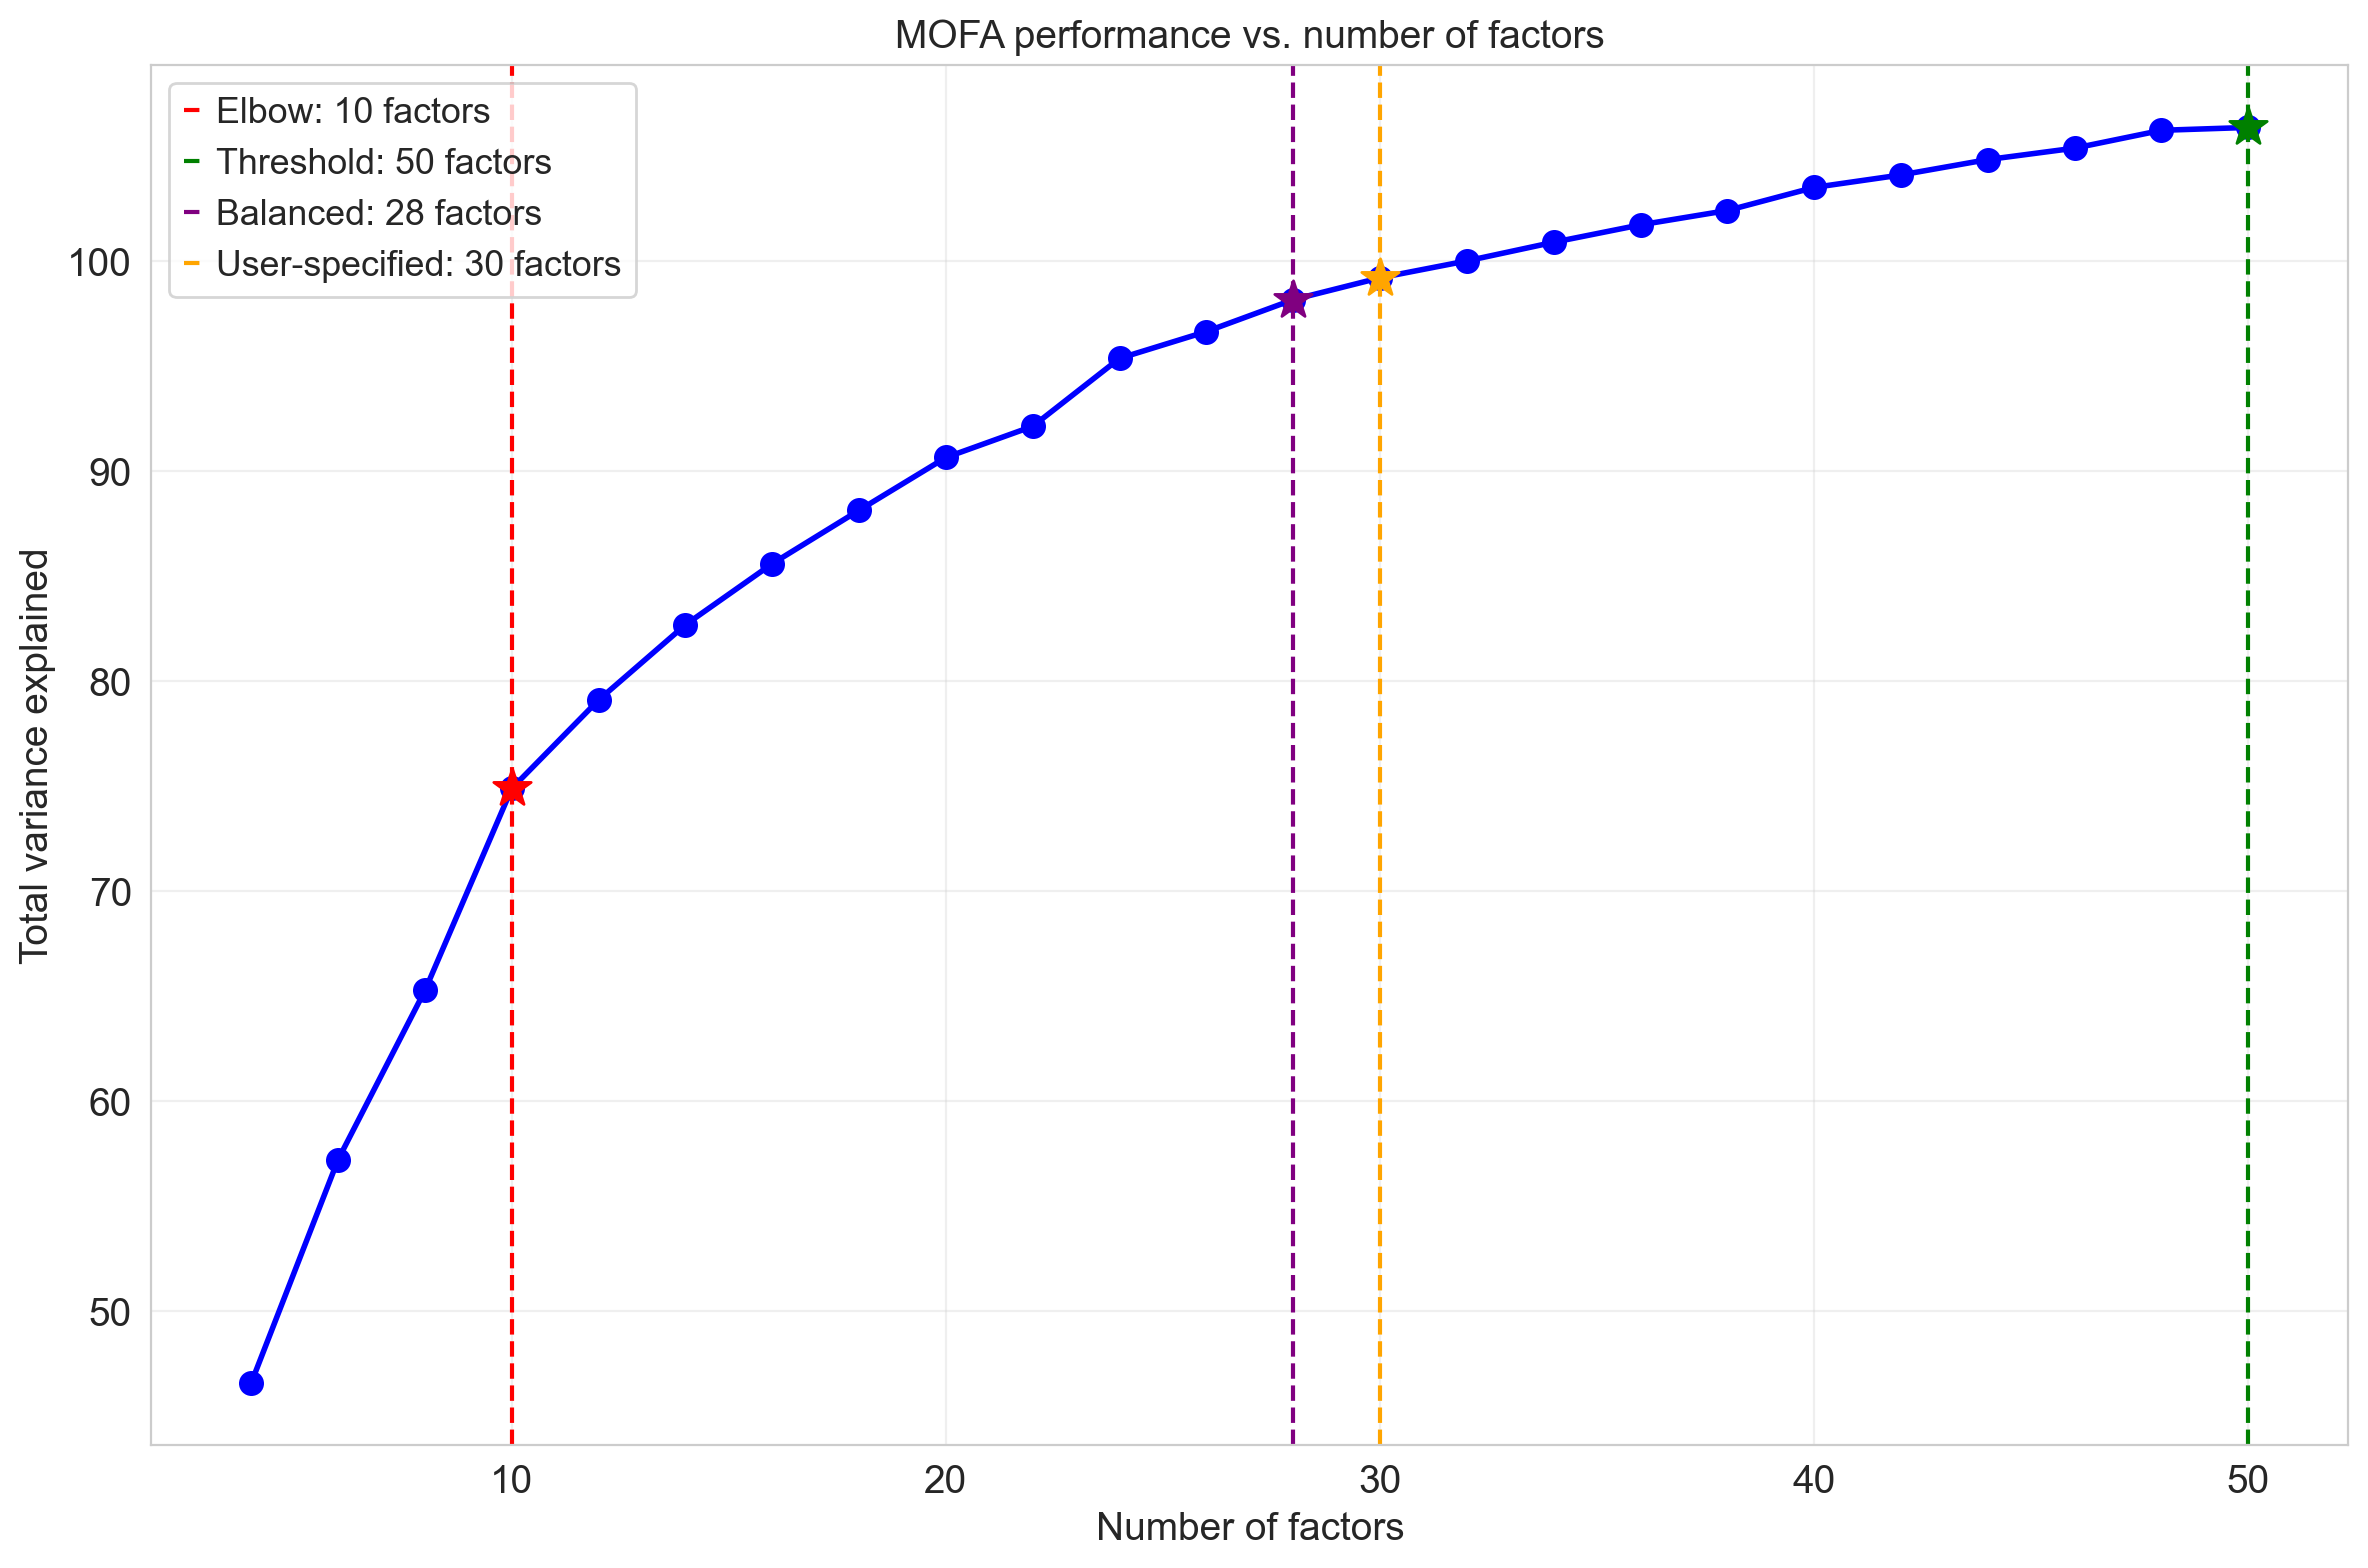

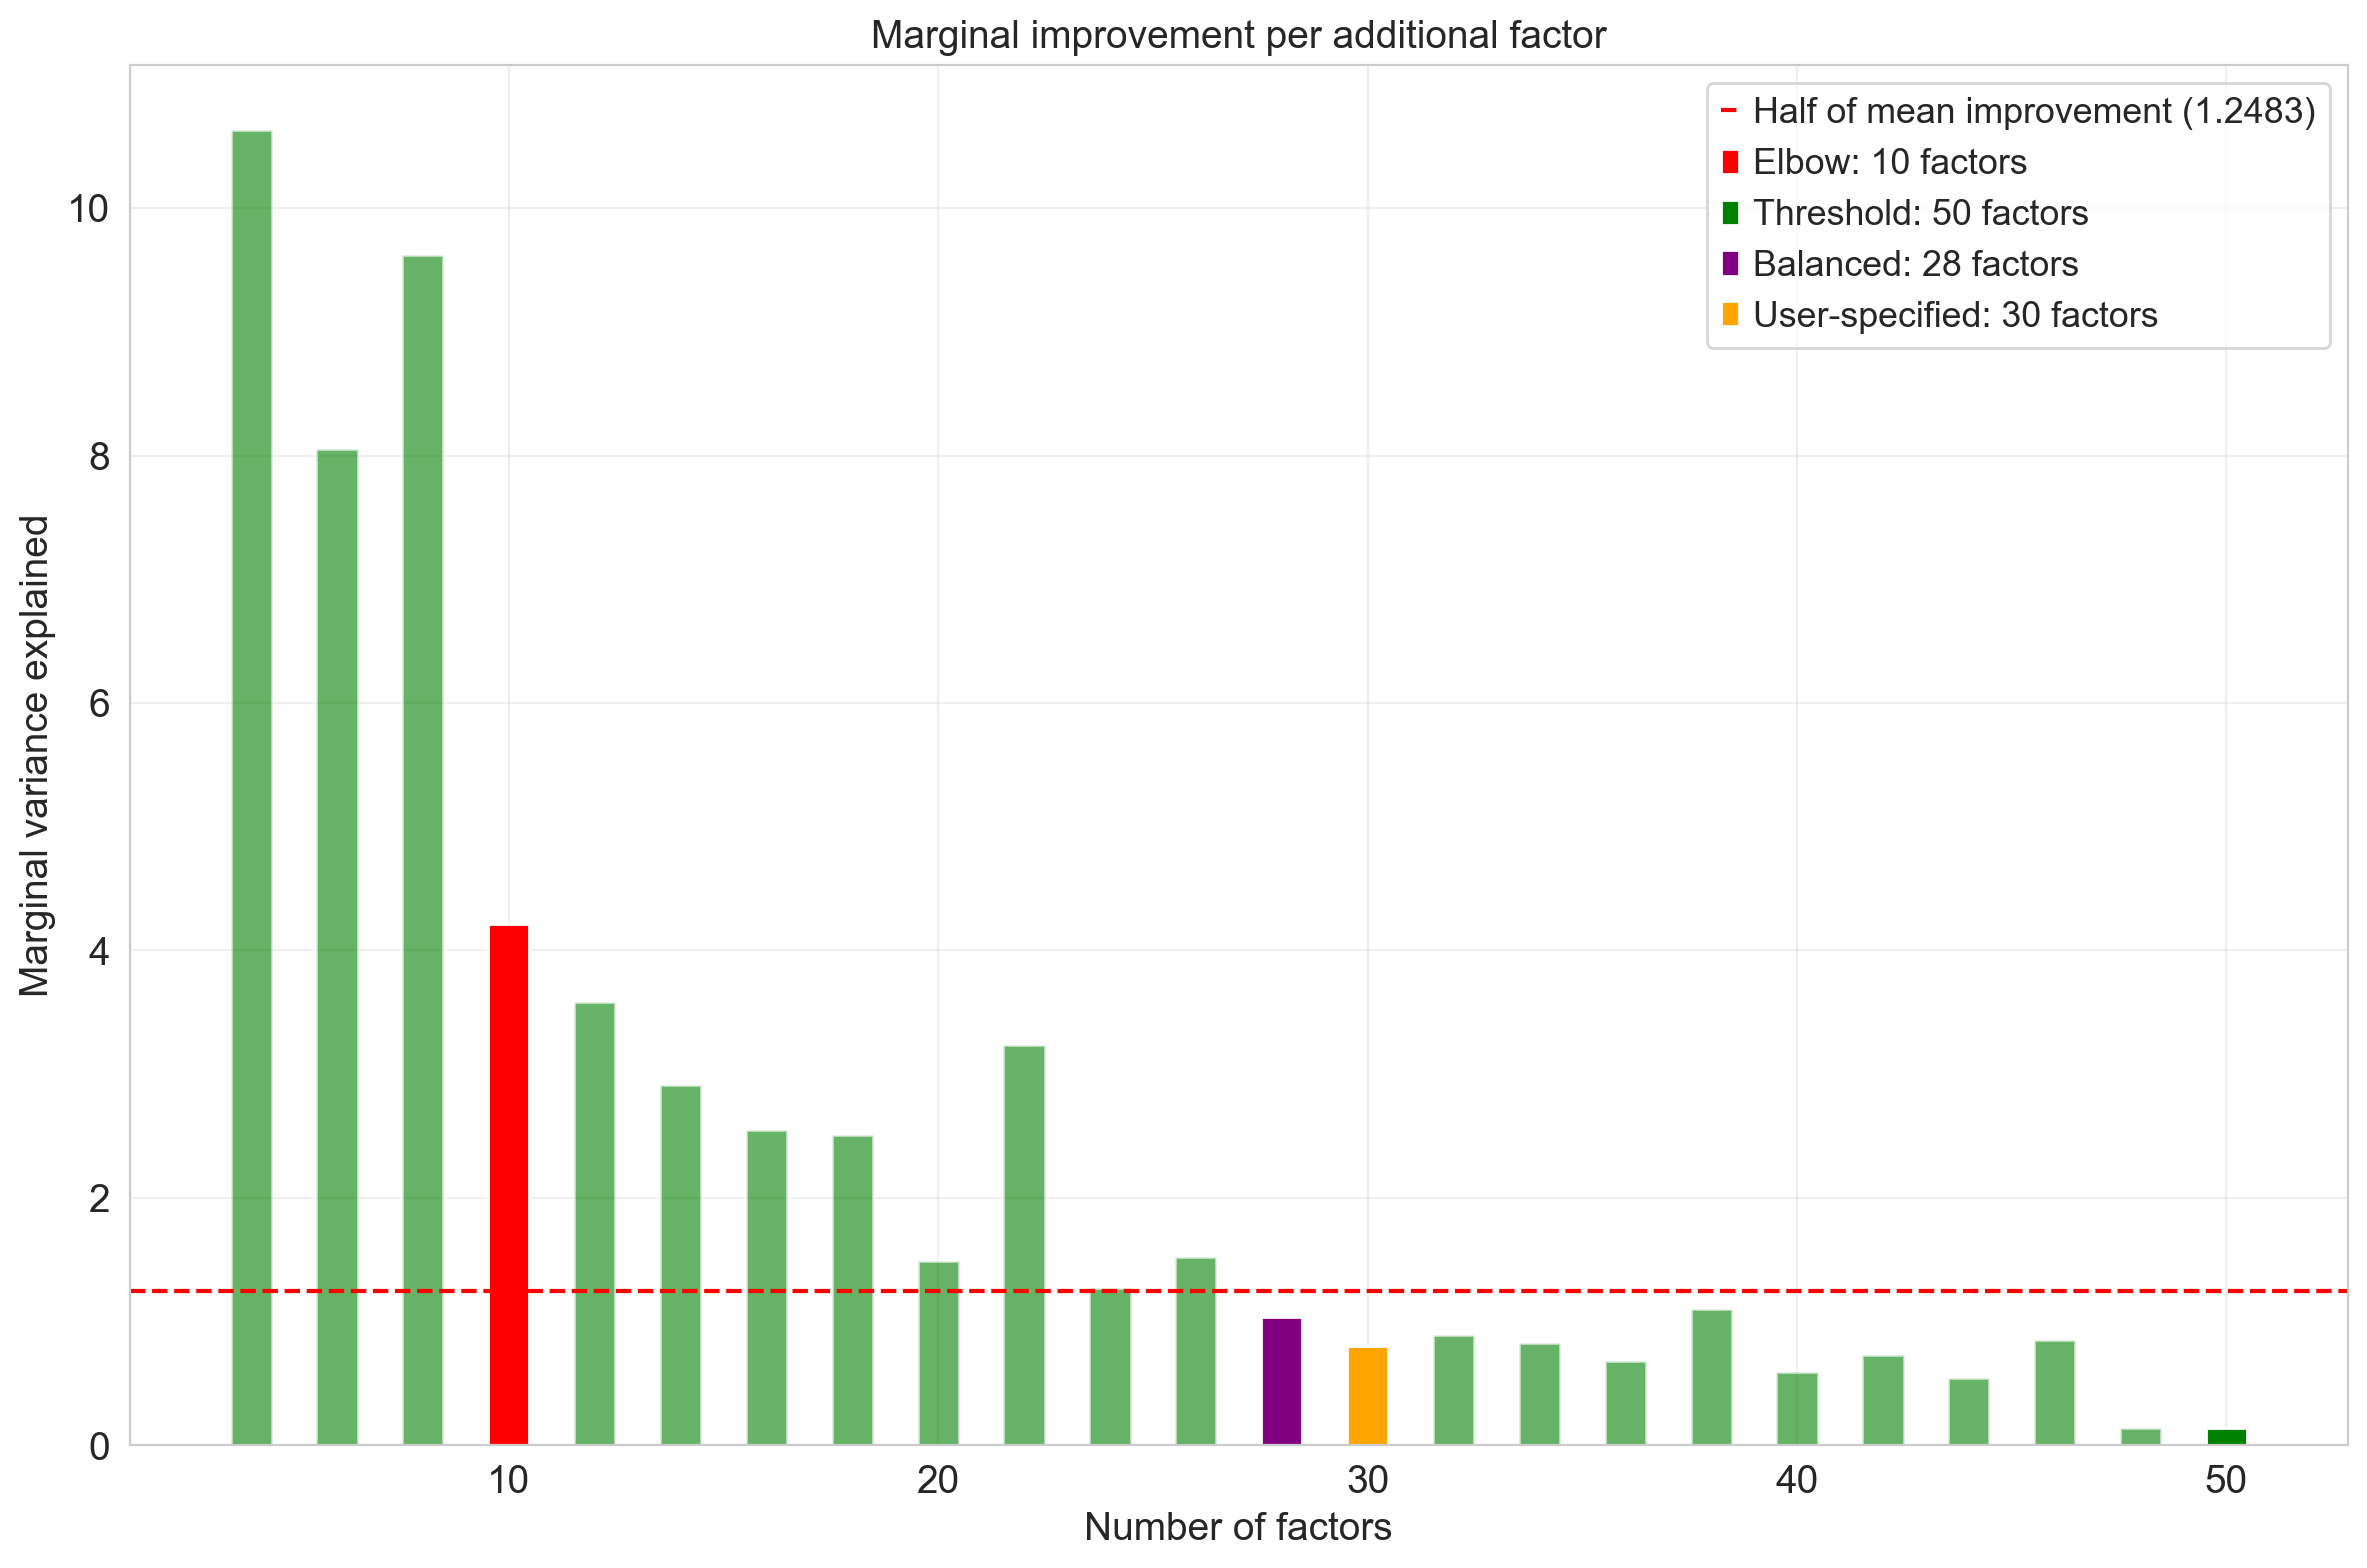

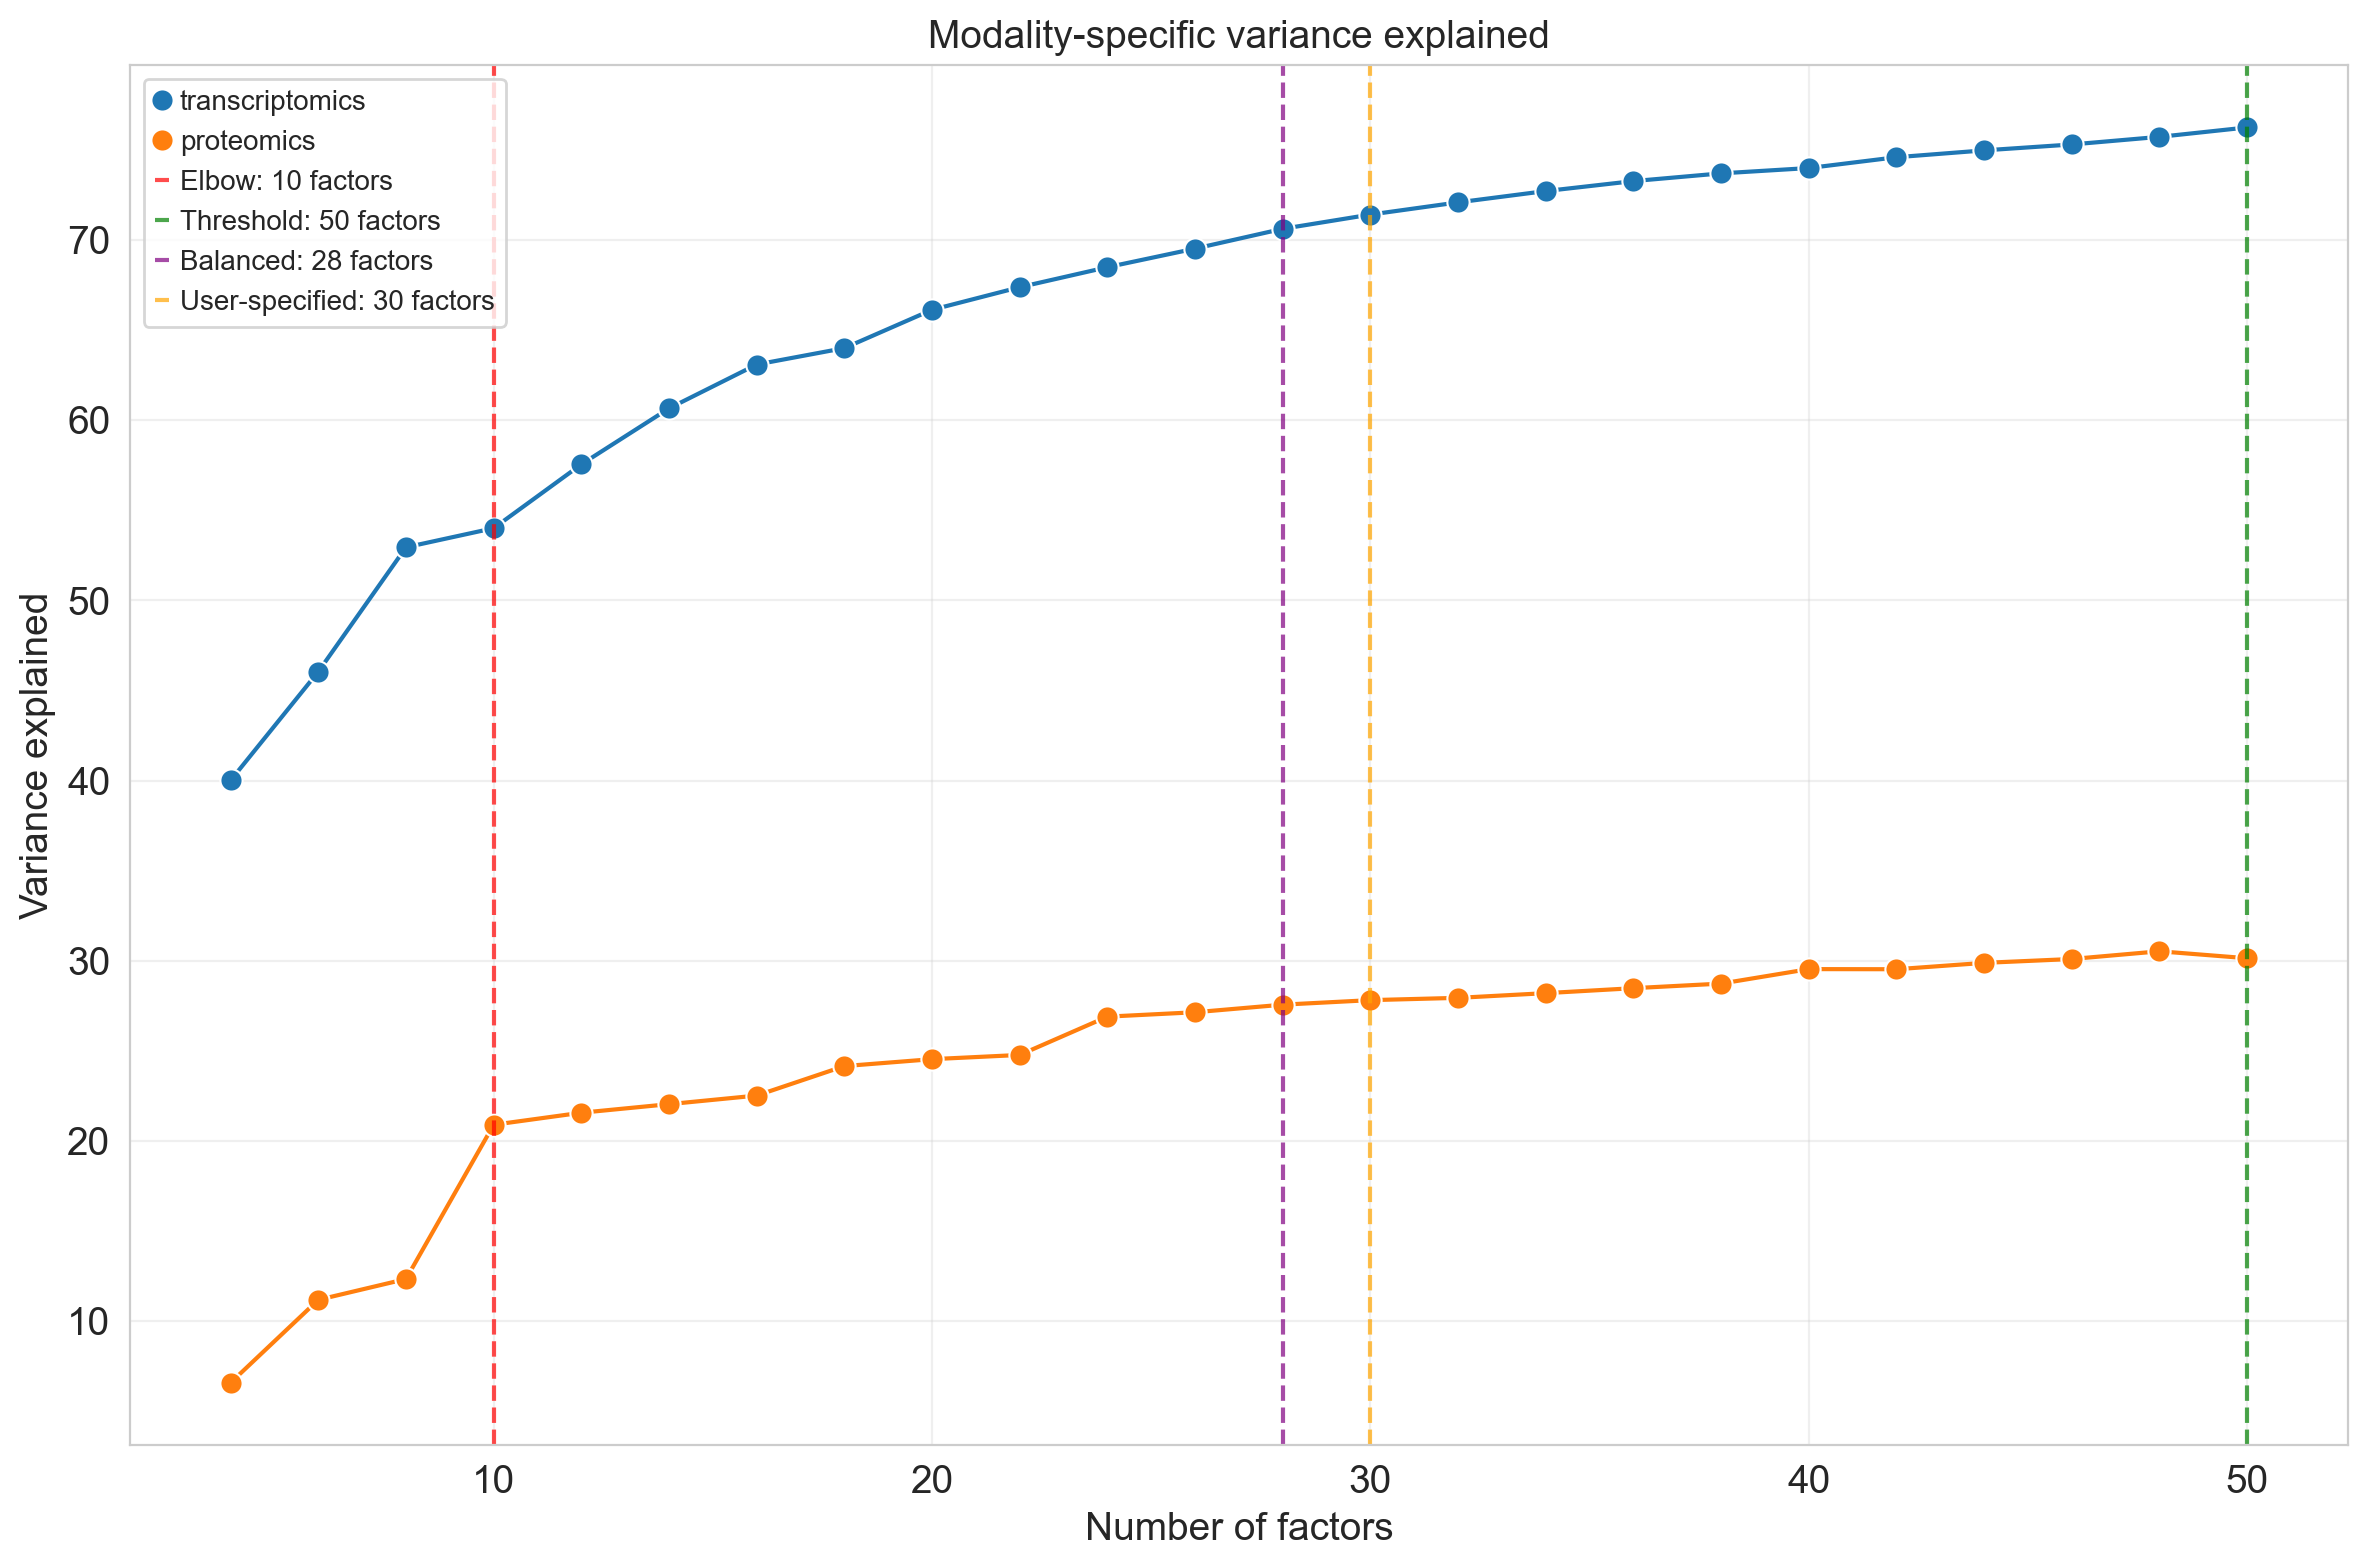

In [25]:
# Run the factor scan
results_dict = factor_analysis.run_mofa_factor_scan(
    intersected_mdata, 
    factor_range=FACTOR_RANGE,
    use_layer=ANALYSIS_LAYER,  # Adjust to your normalized layer
    models_dir=MOFA_PARAM_SCAN_MODELS_PATH,
    overwrite=OVERWRITE
)

# Extract variance metrics from all models
metrics = factor_analysis.calculate_variance_metrics(results_dict)

factor_analysis.visualize_factor_scan_results(metrics, user_factors=OPTIMAL_FACTOR)

In [26]:
import mudata as md

OVERWRITE = False
OPTIMAL_MODEL_H5MU_PATH = "/tmp/mofa_optimal_model.h5mu"

if not os.path.isfile(OPTIMAL_MODEL_H5MU_PATH) or OVERWRITE:

    optimal_model = factor_analysis.create_minimal_mudata(
        intersected_mdata,
        include_layers=[ANALYSIS_LAYER],
        include_obsm=True,
        include_varm=False
    )

    muon.tl.mofa(
        optimal_model,
        n_factors=OPTIMAL_FACTOR,
        use_obs=None,
        use_var=None,
        use_layer=ANALYSIS_LAYER,
        convergence_mode="medium",
        verbose=False,
        save_metadata=True
    )

    md.write_h5mu(OPTIMAL_MODEL_H5MU_PATH, optimal_model)
else:
    optimal_model = md.read_h5mu(OPTIMAL_MODEL_H5MU_PATH)


/Users/maya/Desktop/GITHUB/napistu/lib/napistu-scrapyard/applications/forny_2023/.venv/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/maya/Desktop/GITHUB/napistu/lib/napistu-scrapyard/applications/forny_2023/.venv/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


## Identifying interesting factors

We can generate network representations for each of these factors (based on feature loadings) but there are some that are probably more interesting than others. Ideally some factors capture batch-effects and variation which is independent of disease, while others reflect pathways whose activity varies across measures of MMA pathology (e.g., cases vs. controls).

To identify interesting factors we can compare the the sample usages to disease covariates. Regression is a good way of approaching this but first we need to assess whether loadings are Normally-distributions (technically, just the residuals have to be but the disease influence is relatively weak).

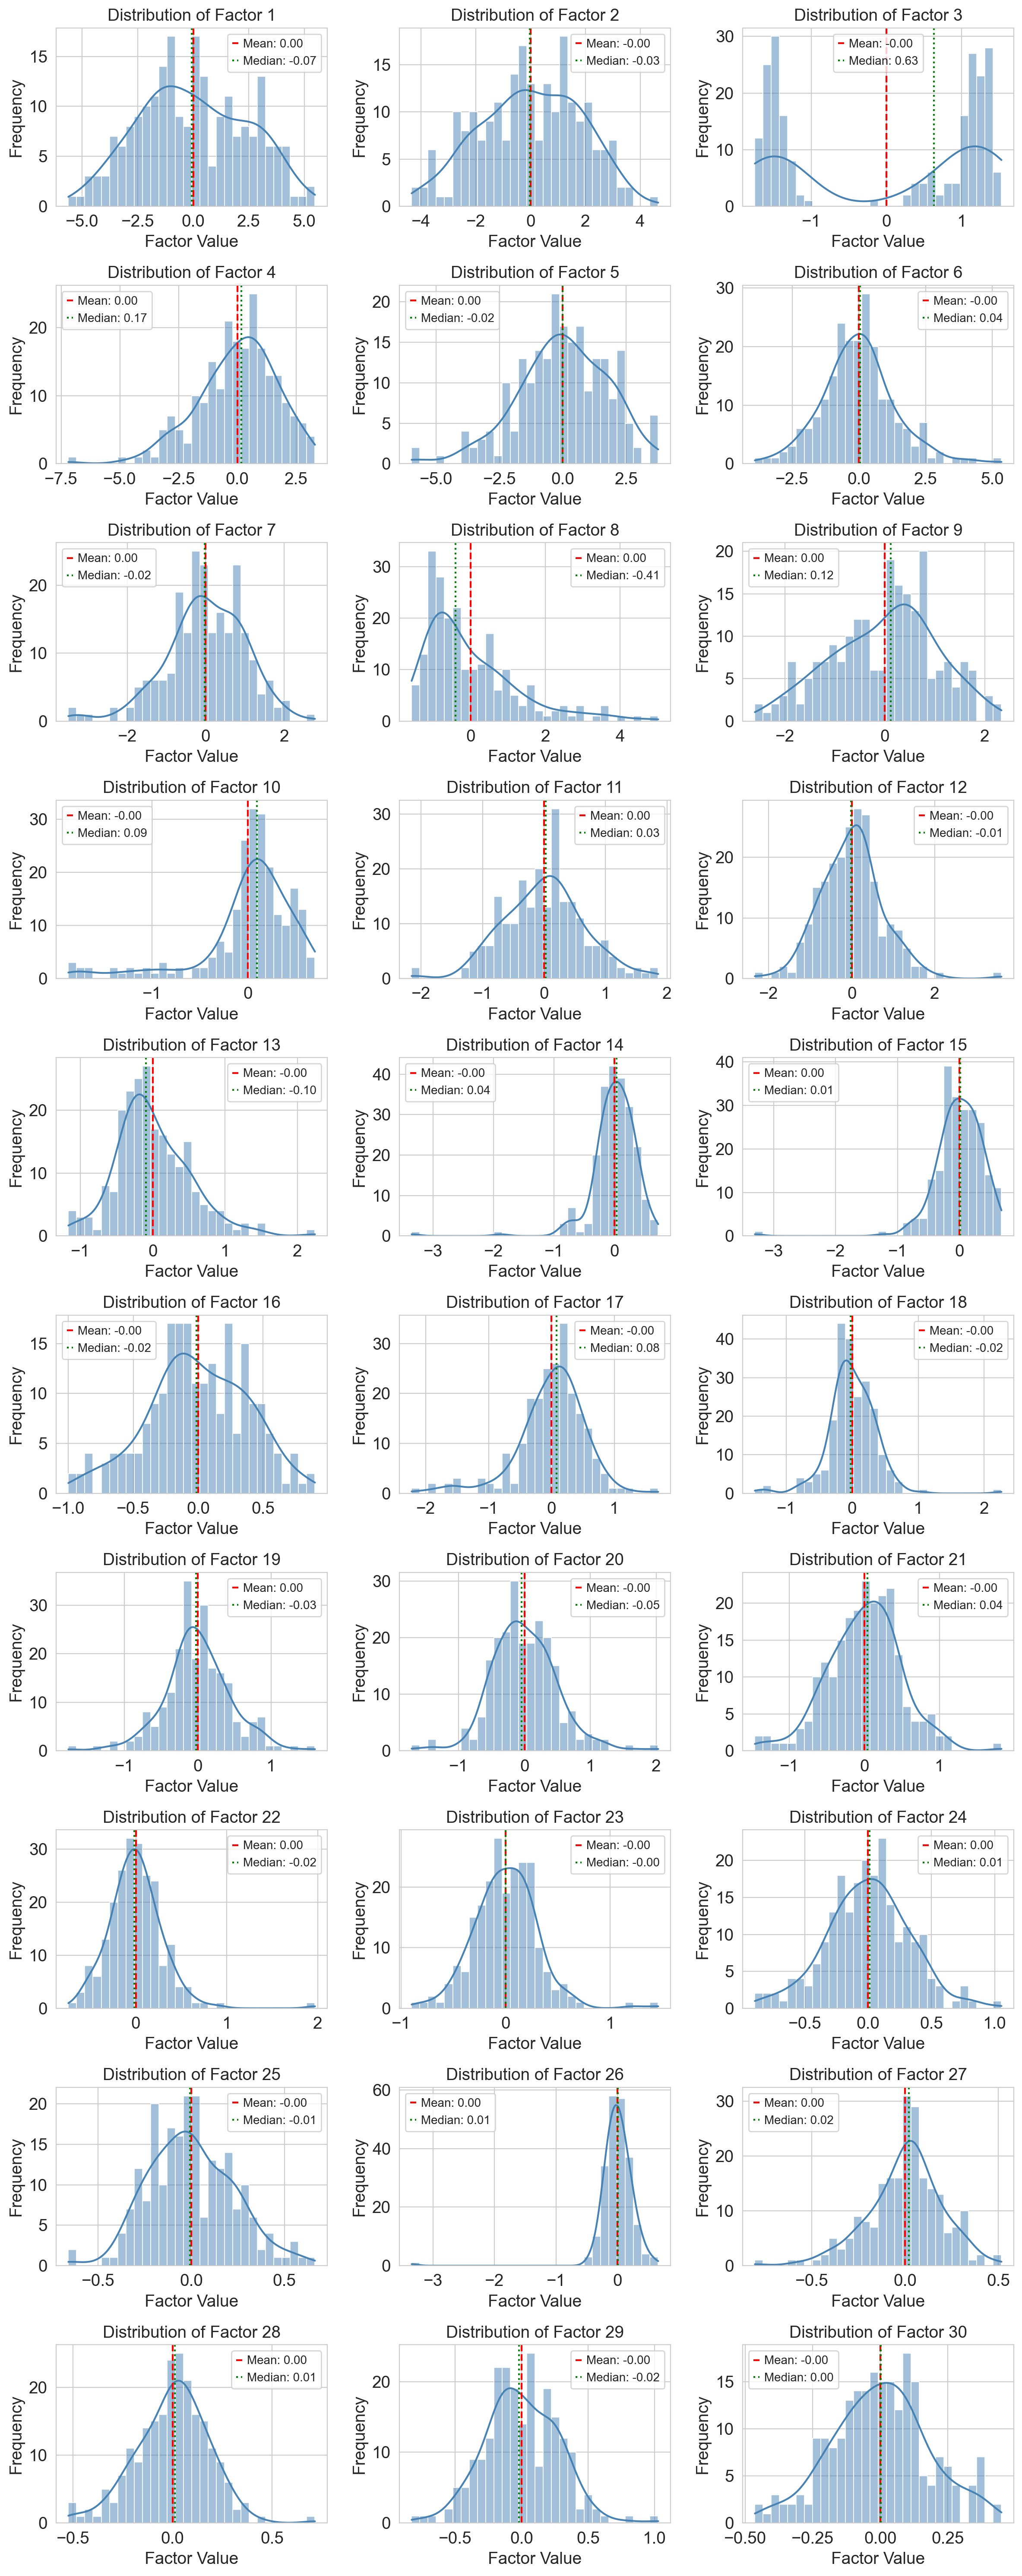

In [27]:
# Plot histograms for all factors
factor_analysis.plot_mofa_factor_histograms(optimal_model)
plt.show()

In [28]:
# Run regression analysis
regression_results = factor_analysis.regress_factors_with_formula(
    optimal_model,
    formula=REGRESSION_FORMULA,
    factors=None  # Use all factors
)

# Generate summary table
summary_table = factor_analysis.summarize_factor_regression(
    regression_results,
    alpha=FDR_CUTOFF,
    group_by_factor=True
)

# Add results to MuData object
factor_analysis.add_regression_to_mudata(
    optimal_model,
    regression_results,
    key_added="factor_regression"
)

Completed regression analysis for 60 factor-term pairs.


In [29]:
regression_results.sort_values("q_value").head(10)

factor_idx factor_name    term  estimate   std_err  statistic   p_value  \
5            2    Factor_3  gender  0.806301  0.169160   4.766506  0.000003   
19           9   Factor_10  gender -0.280272  0.065546  -4.275984  0.000028   
39          19   Factor_20  gender -0.174244  0.065787  -2.648619  0.008673   
35          17   Factor_18  gender -0.116132  0.050212  -2.312819  0.021665   
49          24   Factor_25  gender -0.067854  0.030717  -2.208999  0.028216   
18           9   Factor_10    case  0.275774  0.116382   2.369565  0.018682   
16           8    Factor_9    case -0.643074  0.248085  -2.592148  0.010183   
17           8    Factor_9  gender -0.241374  0.139721  -1.727547  0.085486   
46          23   Factor_24    case  0.153774  0.078200   1.966425  0.050518   
58          29   Factor_30    case -0.056956  0.043265  -1.316446  0.189407   

    conf_int_lower  conf_int_upper   nobs  rsquared  rsquared_adj   q_value  \
5         0.472903        1.139699  221.0  0.095133      0.086832  0.000103   
19       -0.409457       -0.151088  221.0  0.093390      0.085073  0.000427   
39       -0.303904       -0.044585  221.0  0.036159      0.027317  0.086733   
35       -0.215095       -0.017168  221.0  0.024461      0.015511  0.162489   
49       -0.128394       -0.007314  221.0  0.022510      0.013542  0.169295   
18        0.046397        0.505151  221.0  0.093390      0.085073  0.280225   
16       -1.132026       -0.154121  221.0  0.045806      0.037052  0.280225   
17       -0.516750        0.034002  221.0  0.045806      0.037052  0.427428   
46       -0.000350        0.307898  221.0  0.020499      0.011512  0.505185   
58       -0.142227        0.028315  221.0  0.008330     -0.000768  0.676370   

    significant  
5          True  
19         True  
39        False  
35        False  
49        False  
18        False  
16        False  
17        False  
46        False  
58        False